<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-the-Bayesian-Hyperparameter-Optimisation-Algorithm" data-toc-modified-id="Import-the-Bayesian-Hyperparameter-Optimisation-Algorithm-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import the Bayesian Hyperparameter Optimisation Algorithm</a></span></li><li><span><a href="#Example-Use-Case" data-toc-modified-id="Example-Use-Case-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example Use Case</a></span><ul class="toc-item"><li><span><a href="#Generate-some-tarining-data" data-toc-modified-id="Generate-some-tarining-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate some tarining data</a></span></li><li><span><a href="#Run-the-Optimisation" data-toc-modified-id="Run-the-Optimisation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Run the Optimisation</a></span></li><li><span><a href="#Plot-the-Samples" data-toc-modified-id="Plot-the-Samples-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Plot the Samples</a></span></li></ul></li><li><span><a href="#Advanced-User-defined-Inputs" data-toc-modified-id="Advanced-User-defined-Inputs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Advanced User-defined Inputs</a></span><ul class="toc-item"><li><span><a href="#Providing-your-own-scoring-function" data-toc-modified-id="Providing-your-own-scoring-function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Providing your own scoring function</a></span><ul class="toc-item"><li><span><a href="#Example-1" data-toc-modified-id="Example-1-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Example 1</a></span></li><li><span><a href="#Example-2" data-toc-modified-id="Example-2-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Example 2</a></span></li></ul></li><li><span><a href="#Convergence-Diagnostics" data-toc-modified-id="Convergence-Diagnostics-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Convergence Diagnostics</a></span></li></ul></li><li><span><a href="#Using-random_search-solver-for-discrete-valued-hyperparameters" data-toc-modified-id="Using-random_search-solver-for-discrete-valued-hyperparameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Using random_search solver for discrete valued hyperparameters</a></span></li><li><span><a href="#Ignore-this-for-now..." data-toc-modified-id="Ignore-this-for-now...-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Ignore this for now...</a></span></li></ul></div>

In [1]:
# That is setting up the autoreload mode to automatically 
# reload your imports when you edit a file
%load_ext autoreload
%autoreload 2

# Import the Bayesian Hyperparameter Optimisation Algorithm

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
from bayesian_hyperparameter_optimisation_3 import BayesianOptimisation
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, RBF
import matplotlib.pyplot as plt

# Example Use Case
## Generate some tarining data

In [280]:
def generate_noisy_data_from_bivariate_gaussian(z):
    
    "Define a simple 2-D gaussian to generate noisy data"
    
    x = z[:,0].reshape(-1,1)
    y = z[:,1].reshape(-1,1)
    return 1-np.exp(-((x-5)/10)**2)*np.exp(-((y-10)/10)**2)+0.1*np.random.uniform(size=(1000,1))#,loc=0,scale=1)

def generate_noisy_data_from_bivariate_gaussian_nd(z, mu, sig):
    
    "Define a simple 3-D gaussian to generate noisy data"
    
    G = np.ones((z.shape[0],1))
    for i in range(len(mu)):
        G = G*np.exp(-((z[:,i]-mu[i])/sig[i])**2).reshape(-1,1)
    
    return 1-G+0.1*np.random.uniform(size=(1000,1))


# --- Generate our training data

# Generate random x data from 0 to 15
X_train = 15*np.random.uniform(size=(1000,2))
# Generate noisy data from a 2D gaussian defined above
y_train = generate_noisy_data_from_bivariate_gaussian(X_train)
y_train = y_train.ravel()




## Run the Optimisation

In [102]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators':range(1,20),
    'max_depth':range(1,10),
#     'min_samples_leaf': [0.1,0.5]
}

# --- Run the Bayesian Optimisation Code

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = RandomForestRegressor(random_state=42),
    NpI = 5,
    Niter = 95,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 10
)
BOout.optimise()

ndim: 0
{'max_depth': 6, 'n_estimators': 6} score: 0.9593846302314712
{'max_depth': 1, 'n_estimators': 10} score: 0.554417949890885
{'max_depth': 3, 'n_estimators': 2} score: 0.8821281604580913
{'max_depth': 8, 'n_estimators': 13} score: 0.9723970158795666


INFO:root:Will perform 95 iterations
INFO:root:Iteration 0


{'max_depth': 5, 'n_estimators': 17} score: 0.9478169130823251


ValueError: cannot reshape array of size 2 into shape (0)

## Plot the Samples

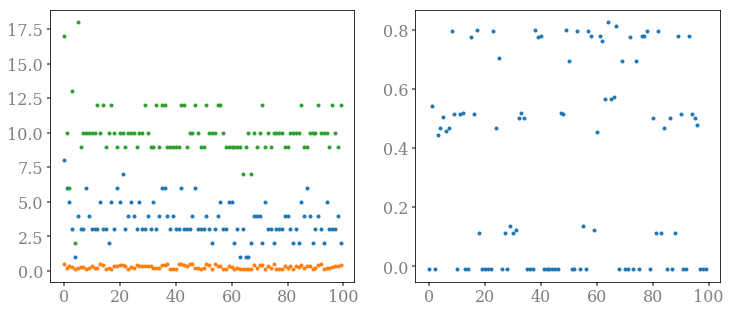

In [36]:
# --- Track the results with each iteration

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(BOout.Xt,'.')
plt.subplot(122)
plt.plot(BOout.Yt,'.')

plt.show()

In [9]:
best_params = BOout.Xt[np.argmax(BOout.Yt)]
RFr = RandomForestRegressor(
    min_samples_leaf=best_params[0],
    random_state=42
).fit(X_train,y_train)
np.mean(cross_val_score(RFr, X_train,y_train, cv=5))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7700969003203069

# Advanced User-defined Inputs
## Providing your own scoring function

### Example 1

In [34]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators':range(1,20),
    'max_depth':range(1,10),
    'min_samples_leaf': [0.1,0.5]
}

# --- Run the Bayesian Optimisation Code
MLmodel = RandomForestRegressor(random_state=42)

def my_scoring_function(X_train, y_train):
    return MLmodel.score(X_train, y_train)

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = MLmodel,
    scoring_function = my_scoring_function,
    NpI = 5,
    Niter = 95,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 10,
).optimise()

INFO:root:Will perform 95 iterations
INFO:root:Iteration 0
INFO:root:Iteration 1


{'max_depth': 1, 'min_samples_leaf': 0.30000000000000004, 'n_estimators': 13} score: 0.44528430312364015
{'max_depth': 3, 'min_samples_leaf': 0.4600000000000001, 'n_estimators': 17} score: -0.008378617416458178
{'max_depth': 6, 'min_samples_leaf': 0.38, 'n_estimators': 2} score: -0.012146062392077406
{'max_depth': 8, 'min_samples_leaf': 0.22000000000000003, 'n_estimators': 10} score: 0.5426162011160974
{'max_depth': 5, 'min_samples_leaf': 0.14, 'n_estimators': 6} score: 0.7782525552890325
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 9} score: 0.12398975013204641
current accuracy: 0.12398975013204641
best accuracy: 0.7782525552890325
next iteration


INFO:root:Iteration 2
INFO:root:Iteration 3
INFO:root:Iteration 4


{'max_depth': 6, 'min_samples_leaf': 0.48, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.48, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.16000000000000003, 'n_estimators': 10} score: 0.7779499751645844
current accuracy: 0.7779499751645844
best accuracy: 0.7782525552890325
next iteration


INFO:root:Iteration 5
INFO:root:Iteration 6
INFO:root:Iteration 7
INFO:root:Iteration 8


{'max_depth': 3, 'min_samples_leaf': 0.24000000000000002, 'n_estimators': 10} score: 0.5148707931739177
current accuracy: 0.5148707931739177
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.2, 'n_estimators': 7} score: 0.6744583836414535
current accuracy: 0.6744583836414535
best accuracy: 0.7782525552890325


INFO:root:Iteration 9
INFO:root:Iteration 10


next iteration
{'max_depth': 4, 'min_samples_leaf': 0.3600000000000001, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.28, 'n_estimators': 10} score: 0.46852619298481
current accuracy: 0.46852619298481
best accuracy: 0.7782525552890325
next iteration


INFO:root:Iteration 11
INFO:root:Iteration 12
INFO:root:Iteration 13


{'max_depth': 4, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 10} score: 0.11200043782181188
current accuracy: 0.11200043782181188
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.4, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.48, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7782525552890325
next iteration


INFO:root:Iteration 14
INFO:root:Iteration 15
INFO:root:Iteration 16


{'max_depth': 6, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.12000000000000001, 'n_estimators': 10} score: 0.7966941788055276
current accuracy: 0.7966941788055276
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.28001474376176705, 'n_estimators': 12} score: 0.47885622560997254
current accuracy: 0.47885622560997254
best accuracy: 0.7966941788055276
next iteration


INFO:root:Iteration 17
INFO:root:Iteration 18
INFO:root:Iteration 19


{'max_depth': 4, 'min_samples_leaf': 0.16000000000000003, 'n_estimators': 10} score: 0.7779499751645844
current accuracy: 0.7779499751645844
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 9} score: 0.12398975013204641
current accuracy: 0.12398975013204641
best accuracy: 0.7966941788055276
next iteration


INFO:root:Iteration 20
INFO:root:Iteration 21
INFO:root:Iteration 22


{'max_depth': 3, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.3600000000000001, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.4800000972976031, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7966941788055276
next iteration


INFO:root:Iteration 23
INFO:root:Iteration 24
INFO:root:Iteration 25


{'max_depth': 5, 'min_samples_leaf': 0.12000000000000001, 'n_estimators': 10} score: 0.7966941788055276
current accuracy: 0.7966941788055276
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.4, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7966941788055276
next iteration


INFO:root:Iteration 26
INFO:root:Iteration 27


{'max_depth': 3, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.11999999872730176, 'n_estimators': 9} score: 0.7981373572444003
current accuracy: 0.7981373572444003
best accuracy: 0.7981373572444003
next iteration


INFO:root:Iteration 28
INFO:root:Iteration 29
INFO:root:Iteration 30


{'max_depth': 6, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7981373572444003
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.4, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7981373572444003
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.2000115685239166, 'n_estimators': 10} score: 0.7043018952806764
current accuracy: 0.7043018952806764
best accuracy: 0.7981373572444003
next iteration


INFO:root:Iteration 31
INFO:root:Iteration 32
INFO:root:Iteration 33


{'max_depth': 5, 'min_samples_leaf': 0.12000000000000001, 'n_estimators': 12} score: 0.8002983920390958
current accuracy: 0.8002983920390958
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.43999545962083364, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 34
INFO:root:Iteration 35
INFO:root:Iteration 36


{'max_depth': 3, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 10} score: 0.11200043782181188
current accuracy: 0.11200043782181188
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.2, 'n_estimators': 9} score: 0.6948271931798515
current accuracy: 0.6948271931798515
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958


INFO:root:Iteration 37
INFO:root:Iteration 38
INFO:root:Iteration 39


next iteration
{'max_depth': 2, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 40
INFO:root:Iteration 41


{'max_depth': 5, 'min_samples_leaf': 0.2, 'n_estimators': 9} score: 0.6948271931798515
current accuracy: 0.6948271931798515
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.3600001036287043, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 42
INFO:root:Iteration 43


{'max_depth': 3, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 10} score: 0.11200043782181188
current accuracy: 0.11200043782181188
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.31999992754119416, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 44
INFO:root:Iteration 45


{'max_depth': 3, 'min_samples_leaf': 0.48, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.1200370370401015, 'n_estimators': 10} score: 0.7966941788055276
current accuracy: 0.7966941788055276
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 46
INFO:root:Iteration 47


{'max_depth': 3, 'min_samples_leaf': 0.39996616040220945, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.12002557953848737, 'n_estimators': 10} score: 0.7966941788055276
current accuracy: 0.7966941788055276
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 48
INFO:root:Iteration 49


{'max_depth': 5, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.11999905591870905, 'n_estimators': 10} score: 0.7964020277097115
current accuracy: 0.7964020277097115
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 50
INFO:root:Iteration 51


{'max_depth': 3, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.27998250288513193, 'n_estimators': 9} score: 0.45290613797064994
current accuracy: 0.45290613797064994
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 52
INFO:root:Iteration 53


{'max_depth': 4, 'min_samples_leaf': 0.48, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.44000003160733664, 'n_estimators': 7} score: -0.010515454502098143
current accuracy: -0.010515454502098143
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 54
INFO:root:Iteration 55


{'max_depth': 2, 'min_samples_leaf': 0.31998306180655145, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.4399842839172108, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 56
INFO:root:Iteration 57


{'max_depth': 6, 'min_samples_leaf': 0.1999983346845634, 'n_estimators': 9} score: 0.6948271931798515
current accuracy: 0.6948271931798515
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.24003166356066233, 'n_estimators': 9} score: 0.5022439460506452
current accuracy: 0.5022439460506452
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 58
INFO:root:Iteration 59


{'max_depth': 6, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.31999820241602606, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 60
INFO:root:Iteration 61


{'max_depth': 3, 'min_samples_leaf': 0.4, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.48, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 62
INFO:root:Iteration 63


{'max_depth': 5, 'min_samples_leaf': 0.36000018577592724, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.31999681829377796, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 64
INFO:root:Iteration 65


{'max_depth': 4, 'min_samples_leaf': 0.12001909583602356, 'n_estimators': 10} score: 0.7966941788055276
current accuracy: 0.7966941788055276
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.3999864330746391, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 66
INFO:root:Iteration 67


{'max_depth': 5, 'min_samples_leaf': 0.43998636646125766, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.23999122820306898, 'n_estimators': 9} score: 0.5030954049197514
current accuracy: 0.5030954049197514
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 68
INFO:root:Iteration 69


{'max_depth': 5, 'min_samples_leaf': 0.4399857225319034, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.47992457144770695, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 70
INFO:root:Iteration 71


{'max_depth': 3, 'min_samples_leaf': 0.11999624486391751, 'n_estimators': 9} score: 0.7981373572444003
current accuracy: 0.7981373572444003
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.39996194155471587, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 72
INFO:root:Iteration 73


{'max_depth': 6, 'min_samples_leaf': 0.24002371081611523, 'n_estimators': 10} score: 0.5148707931739177
current accuracy: 0.5148707931739177
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.23999989870287225, 'n_estimators': 10} score: 0.5156684657279785
current accuracy: 0.5156684657279785
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 74
INFO:root:Iteration 75


{'max_depth': 3, 'min_samples_leaf': 0.16003943457918282, 'n_estimators': 9} score: 0.7758889566588596
current accuracy: 0.7758889566588596
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 7, 'min_samples_leaf': 0.11999852177807155, 'n_estimators': 10} score: 0.7964020277097115
current accuracy: 0.7964020277097115
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 76
INFO:root:Iteration 77


{'max_depth': 4, 'min_samples_leaf': 0.3199459543431613, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.28, 'n_estimators': 9} score: 0.45724519226796384
current accuracy: 0.45724519226796384
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 78
INFO:root:Iteration 79


{'max_depth': 3, 'min_samples_leaf': 0.31999305092893116, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.35999837553072195, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 80
INFO:root:Iteration 81


{'max_depth': 3, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 10} score: 0.11200043782181188
current accuracy: 0.11200043782181188
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.4, 'n_estimators': 12} score: -0.008587570224572082
current accuracy: -0.008587570224572082
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 82
INFO:root:Iteration 83


{'max_depth': 2, 'min_samples_leaf': 0.2, 'n_estimators': 10} score: 0.7057872101137947
current accuracy: 0.7057872101137947
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.15999878735054424, 'n_estimators': 9} score: 0.7772455185040268
current accuracy: 0.7772455185040268
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 84
INFO:root:Iteration 85


{'max_depth': 3, 'min_samples_leaf': 0.28, 'n_estimators': 10} score: 0.46852619298481
current accuracy: 0.46852619298481
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 10} score: 0.11200043782181188
current accuracy: 0.11200043782181188
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 86
INFO:root:Iteration 87


{'max_depth': 4, 'min_samples_leaf': 0.11999085721966167, 'n_estimators': 7} score: 0.7962059664031744
current accuracy: 0.7962059664031744
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.3600000000000001, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 88
INFO:root:Iteration 89


{'max_depth': 3, 'min_samples_leaf': 0.12000000000000001, 'n_estimators': 9} score: 0.7990162760853565
current accuracy: 0.7990162760853565
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.39995252686346705, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 90
INFO:root:Iteration 91


{'max_depth': 3, 'min_samples_leaf': 0.4799982599970509, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.4399880095913341, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 92
INFO:root:Iteration 93
INFO:root:Iteration 94


{'max_depth': 4, 'min_samples_leaf': 0.12000000000000001, 'n_estimators': 9} score: 0.7990162760853565
current accuracy: 0.7990162760853565
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.28, 'n_estimators': 10} score: 0.46852619298481
current accuracy: 0.46852619298481
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Best result 0.8002983920390958: Params: [ 5.    0.12 12.  ]
INFO:root:Best result 0.8002983920390958: Params: {'bootstrap': 5.0, 'criterion': 0.12000000000000001, 'max_depth': 12.0}


{'max_depth': 5, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 9} score: 0.12398975013204641
current accuracy: 0.12398975013204641
best accuracy: 0.8002983920390958


### Example 2

In [ ]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators':range(1,20),
    'max_depth':range(1,10),
    'min_samples_leaf': [0.1,0.5]
}

# --- Run the Bayesian Optimisation Code
MLmodel = RandomForestRegressor(random_state=42)

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = MLmodel,
    scoring_function = MLmodel.score,
    NpI = 5,
    Niter = 95,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 10,
).optimise()

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
INFO:root:Will perform 95 iterations
INFO:root:Iteration 0
INFO:root:Iteration 1
INFO:root:Iteration 2


{'min_samples_leaf': 0.22000000000000003} 0.4813176890428952
{'min_samples_leaf': 0.14} 0.7611842226514938
{'min_samples_leaf': 0.4600000000000001} -8.105585937734361e-05
{'min_samples_leaf': 0.30000000000000004} 0.4181731386486091
{'min_samples_leaf': 0.38} -8.105585937734361e-05
{'min_samples_leaf': 0.16000000000000003} 0.7506234076621161
current accuracy: 0.7506234076621161
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14500071901704767} 0.758548068733668
current accuracy: 0.758548068733668
best accuracy: 0.7611842226514938


INFO:root:Iteration 3
INFO:root:Iteration 4
INFO:root:Iteration 5


{'min_samples_leaf': 0.14359800654588614} 0.7597490697232373
current accuracy: 0.7597490697232373
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14281551301451326} 0.7604543509917512
current accuracy: 0.7604543509917512
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1423166685308091} 0.7604543509917512
current accuracy: 0.7604543509917512
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14197114286162132} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938


INFO:root:Iteration 6
INFO:root:Iteration 7
INFO:root:Iteration 8
INFO:root:Iteration 9


{'min_samples_leaf': 0.141717220259729} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1415226278231482} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1413687435551261} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938


INFO:root:Iteration 10
INFO:root:Iteration 11
INFO:root:Iteration 12


{'min_samples_leaf': 0.14124389354935635} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14114050141384749} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14105347788853914} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938


INFO:root:Iteration 13
INFO:root:Iteration 14


{'min_samples_leaf': 0.14097910774705696} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14091472897980928} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1408586094476931} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 15
INFO:root:Iteration 16
INFO:root:Iteration 17
INFO:root:Iteration 18


{'min_samples_leaf': 0.14080913192964453} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1407652305916371} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14072592861226316} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 19
INFO:root:Iteration 20
INFO:root:Iteration 21


{'min_samples_leaf': 0.1406906148518981} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1406587097872982} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1406297208136269} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 22
INFO:root:Iteration 23
INFO:root:Iteration 24


{'min_samples_leaf': 0.1406032882885509} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14057893927770826} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14055663146242953} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 25
INFO:root:Iteration 26
INFO:root:Iteration 27


{'min_samples_leaf': 0.14053592379649466} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1405169350284069} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14049921494078055} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 28
INFO:root:Iteration 29
INFO:root:Iteration 30


{'min_samples_leaf': 0.14048271698603643} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.140467070884656} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14045270548183333} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 31
INFO:root:Iteration 32
INFO:root:Iteration 33


{'min_samples_leaf': 0.14043920429979037} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14042662126576239} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1404145191303343} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 34
INFO:root:Iteration 35


{'min_samples_leaf': 0.14040306855642762} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1403924885252998} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 36
INFO:root:Iteration 37


{'min_samples_leaf': 0.14038238251857807} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1403726310805419} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 38
INFO:root:Iteration 39
INFO:root:Iteration 40


{'min_samples_leaf': 0.14036362454534673} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14035470709928402} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14034680809441266} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 41
INFO:root:Iteration 42


{'min_samples_leaf': 0.14033900927495396} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14033150207357958} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 43
INFO:root:Iteration 44


{'min_samples_leaf': 0.1403241481248132} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14031738468992408} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 45
INFO:root:Iteration 46


{'min_samples_leaf': 0.14031080911750027} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14030458378668806} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 47
INFO:root:Iteration 48


{'min_samples_leaf': 0.14029853497401615} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14029275754677403} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 49
INFO:root:Iteration 50


{'min_samples_leaf': 0.1402871904764465} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14028195937492788} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


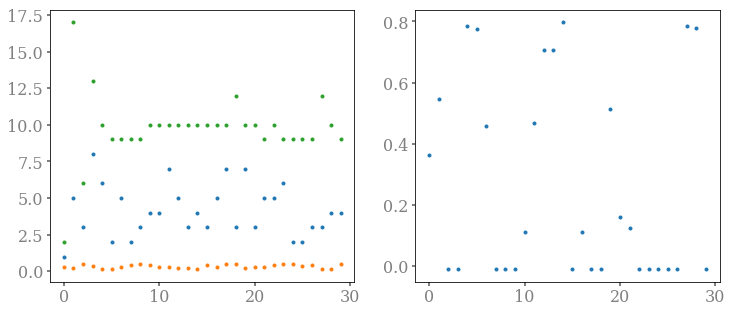

In [40]:
# --- Track the results with each iteration

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(BOout.Xt,'.')
plt.subplot(122)
plt.plot(BOout.Yt,'.')

plt.show()

## Convergence Diagnostics
Plot the convergence of the hyper parameters with each iteration

In [8]:
hps = {
    'n_estimators':range(1,20),
    'max_depth':range(1,10),
    'min_samples_leaf': [0.1,0.5]
}

# --- Run the Bayesian Optimisation Code
MLmodel = RandomForestRegressor(random_state=42)

noise = 0.05
BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = MLmodel,
    NpI = 5,
    Niter = 25,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 10
).optimise()

[autoreload of bayesian_hyperparameter_optimisation_3 failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/crookm12/Documents/GitHub/BayesianOpt

ndim: 1
{'max_depth': 3, 'min_samples_leaf': 0.30000000000000004, 'n_estimators': 13} score: 0.3336931732685191
{'max_depth': 1, 'min_samples_leaf': 0.38, 'n_estimators': 2} score: -0.004065434124759504
{'max_depth': 8, 'min_samples_leaf': 0.22000000000000003, 'n_estimators': 17} score: 0.46907179009709593
{'max_depth': 6, 'min_samples_leaf': 0.4600000000000001, 'n_estimators': 6} score: -0.003851707134288196


INFO:root:Will perform 25 iterations
INFO:root:Iteration 0


{'max_depth': 5, 'min_samples_leaf': 0.14, 'n_estimators': 10} score: 0.7835089048503446
optim rout: minimize
Ncontinous_hps: 1


AttributeError: 'iteration' object has no attribute 'discrete_values'

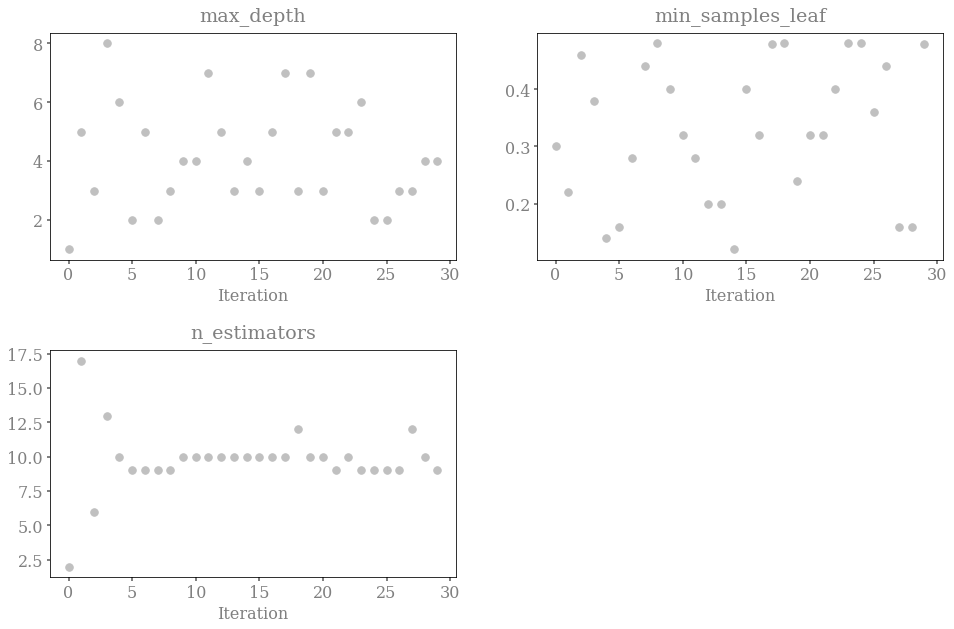

In [39]:
BOout.hyperparameter_convergence_plots()

# Using random_search solver for discrete valued hyperparameters

In [330]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators':range(1,10),
    'max_depth':range(1,10),
    'min_samples_leaf': [0.001, 0.5]
}

training_size = 1000
X_train = 15*np.random.uniform(size=(1000,len(hps)))
# Generate noisy data from a 2D gaussian defined above
y_train = generate_noisy_data_from_bivariate_gaussian_nd(X_train, mu = [5, 10, 15], sig = [1, 5, 10])
y_train = y_train.ravel()

# --- Run the Bayesian Optimisation Code

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = RandomForestRegressor(random_state=42),
    NpI = 5,
    Niter = 300,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 30,
    optim_rout = 'random_search',
    noise = 0.01
)
BOout.optimise()

INFO:root:Will perform 300 iterations
INFO:root:Iteration 0
INFO:root:Iteration 1


{'max_depth': 8, 'min_samples_leaf': 0.27440565927807453, 'n_estimators': 6} score: 0.09594164228226185
{'max_depth': 9, 'min_samples_leaf': 0.15985135233395603, 'n_estimators': 9} score: 0.10075727457284285
{'max_depth': 9, 'min_samples_leaf': 0.08695274320038186, 'n_estimators': 2} score: 0.43599580899777035
{'max_depth': 7, 'min_samples_leaf': 0.10271071071832248, 'n_estimators': 5} score: 0.40323359539904435
{'max_depth': 3, 'min_samples_leaf': 0.4016141661994959, 'n_estimators': 5} score: -0.01172851820884908
final res: t[[7.         0.28500027 4.        ]], [-0.39396223]
{'max_depth': 7, 'min_samples_leaf': 0.28500026550705804, 'n_estimators': 4} score: 0.08862960576645651
current accuracy: 0.08862960576645651
best accuracy: 0.43599580899777035


INFO:root:Iteration 2
INFO:root:Iteration 3


final res: t[[8.e+00 1.e-03 1.e+00]], [-0.02970913]
{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.8134544573126092
current accuracy: 0.8134544573126092
best accuracy: 0.8134544573126092
final res: t[[4.e+00 1.e-03 1.e+00]], [-0.03708396]
{'max_depth': 4, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.7375377772617231
current accuracy: 0.7375377772617231
best accuracy: 0.8134544573126092


INFO:root:Iteration 4
INFO:root:Iteration 5


final res: t[[4.e+00 1.e-03 1.e+00]], [-0.03193504]
{'max_depth': 4, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.7375377772617231
current accuracy: 0.7375377772617231
best accuracy: 0.8134544573126092
final res: t[[1.    0.001 1.   ]], [-0.02028473]
{'max_depth': 1, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.08272679269595332
current accuracy: 0.08272679269595332
best accuracy: 0.8134544573126092
final res: t[[6.e+00 1.e-03 1.e+00]], [-0.08543186]


INFO:root:Iteration 6
INFO:root:Iteration 7


{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 1} score: 0.826639251994225
current accuracy: 0.826639251994225
best accuracy: 0.826639251994225
final res: t[[6.e+00 1.e-03 1.e+00]], [-0.01913202]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.826639251994225
current accuracy: 0.826639251994225
best accuracy: 0.826639251994225
final res: t[[5.e+00 1.e-03 9.e+00]], [-0.00130669]


INFO:root:Iteration 8
INFO:root:Iteration 9


{'max_depth': 5, 'min_samples_leaf': 0.0009999999999999454, 'n_estimators': 9} score: 0.8364963901229556
current accuracy: 0.8364963901229556
best accuracy: 0.8364963901229556
final res: t[[2.e+00 1.e-03 9.e+00]], [-0.03843516]
{'max_depth': 2, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 9} score: 0.43882353915942546
current accuracy: 0.43882353915942546
best accuracy: 0.8364963901229556
final res: t[[5.e+00 1.e-03 9.e+00]], [-0.01288374]


INFO:root:Iteration 10
INFO:root:Iteration 11


{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 9} score: 0.8364963901229556
current accuracy: 0.8364963901229556
best accuracy: 0.8364963901229556
final res: t[[5.  0.5 9. ]], [-0.01056652]
{'max_depth': 5, 'min_samples_leaf': 0.5, 'n_estimators': 9} score: -0.010569605254464287
current accuracy: -0.010569605254464287
best accuracy: 0.8364963901229556


INFO:root:Iteration 12


final res: t[[4.e+00 1.e-03 8.e+00]], [-0.18133954]
{'max_depth': 4, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.7817383923885345
current accuracy: 0.7817383923885345
best accuracy: 0.8364963901229556


INFO:root:Iteration 13


final res: t[[6.e+00 1.e-03 7.e+00]], [-0.19724986]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8534690540930964
current accuracy: 0.8534690540930964
best accuracy: 0.8534690540930964
final res: t[[6.e+00 1.e-03 7.e+00]], [-0.03153228]


INFO:root:Iteration 14
INFO:root:Iteration 15


{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.8534690540930964
current accuracy: 0.8534690540930964
best accuracy: 0.8534690540930964
final res: t[[6.  0.5 1. ]], [-0.02615563]
{'max_depth': 6, 'min_samples_leaf': 0.5, 'n_estimators': 1} score: -0.01911756274176941
current accuracy: -0.01911756274176941
best accuracy: 0.8534690540930964


INFO:root:Iteration 16


final res: t[[5.e+00 1.e-03 1.e+00]], [-0.22199759]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.7654392260036406
current accuracy: 0.7654392260036406
best accuracy: 0.8534690540930964
final res: t[[5.e+00 1.e-03 7.e+00]], [-0.16958187]


INFO:root:Iteration 17
INFO:root:Iteration 18


{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.837046719025978
current accuracy: 0.837046719025978
best accuracy: 0.8534690540930964
final res: t[[1.e+00 1.e-03 7.e+00]], [-0.08396725]
{'max_depth': 1, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.09915909564612083
current accuracy: 0.09915909564612083
best accuracy: 0.8534690540930964


INFO:root:Iteration 19


final res: t[[4.e+00 1.e-03 3.e+00]], [-0.05938276]
{'max_depth': 4, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.7602082601806365
current accuracy: 0.7602082601806365
best accuracy: 0.8534690540930964


INFO:root:Iteration 20


final res: t[[6.e+00 1.e-03 8.e+00]], [-0.04502167]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8585267678580328


INFO:root:Iteration 21
INFO:root:Iteration 22


final res: t[[9.e+00 1.e-03 1.e+00]], [-0.04010137]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 1} score: 0.8061935672204796
current accuracy: 0.8061935672204796
best accuracy: 0.8585267678580328
final res: t[[5.e+00 1.e-03 2.e+00]], [-0.02514207]
{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 2} score: 0.7973119207470744
current accuracy: 0.7973119207470744
best accuracy: 0.8585267678580328


INFO:root:Iteration 23


final res: t[[6.e+00 1.e-03 8.e+00]], [-0.02354341]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8585267678580328
final res: t[[5.e+00 1.e-03 6.e+00]], [-0.01297737]


INFO:root:Iteration 24
INFO:root:Iteration 25


{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 6} score: 0.8400175270016476
current accuracy: 0.8400175270016476
best accuracy: 0.8585267678580328
final res: t[[5.e+00 1.e-03 4.e+00]], [-0.00385817]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 4} score: 0.8265450198910773
current accuracy: 0.8265450198910773
best accuracy: 0.8585267678580328


INFO:root:Iteration 26
INFO:root:Iteration 27


final res: t[[5.e+00 1.e-03 7.e+00]], [-0.01794513]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.837046719025978
current accuracy: 0.837046719025978
best accuracy: 0.8585267678580328
final res: t[[9.e+00 1.e-03 1.e+00]], [-0.00970986]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.8061935672204796
current accuracy: 0.8061935672204796
best accuracy: 0.8585267678580328


INFO:root:Iteration 28
INFO:root:Iteration 29


final res: t[[5.e+00 1.e-03 3.e+00]], [-0.00572797]
{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.8132778992257981
current accuracy: 0.8132778992257981
best accuracy: 0.8585267678580328
final res: t[[6.e+00 1.e-03 7.e+00]], [-0.01095823]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000078, 'n_estimators': 7} score: 0.8534690540930964
current accuracy: 0.8534690540930964
best accuracy: 0.8585267678580328


INFO:root:Iteration 30


final res: t[[6.e+00 1.e-03 8.e+00]], [-0.00975597]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8585267678580328
final res: t[[5.e+00 1.e-03 7.e+00]], [-0.01460305]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.837046719025978
current accuracy: 0.837046719025978
best accuracy: 0.8585267678580328


INFO:root:Iteration 31
INFO:root:Iteration 32
INFO:root:Iteration 33


final res: t[[5.e+00 1.e-03 8.e+00]], [-0.01196245]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8377208745081685
current accuracy: 0.8377208745081685
best accuracy: 0.8585267678580328
final res: t[[5.e+00 1.e-03 2.e+00]], [-0.00495978]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 2} score: 0.7973119207470744
current accuracy: 0.7973119207470744
best accuracy: 0.8585267678580328


INFO:root:Iteration 34


final res: t[[5.e+00 1.e-03 8.e+00]], [-0.00944318]
{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8377208745081685
current accuracy: 0.8377208745081685
best accuracy: 0.8585267678580328
final res: t[[6.e+00 1.e-03 7.e+00]], [-0.01015956]


INFO:root:Iteration 35
INFO:root:Iteration 36


{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.8534690540930964
current accuracy: 0.8534690540930964
best accuracy: 0.8585267678580328
final res: t[[6.e+00 1.e-03 7.e+00]], [-0.00898269]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000148, 'n_estimators': 7} score: 0.8534690540930964
current accuracy: 0.8534690540930964
best accuracy: 0.8585267678580328


INFO:root:Iteration 37
INFO:root:Iteration 38


final res: t[[5.e+00 1.e-03 3.e+00]], [-0.00265862]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 3} score: 0.8132778992257981
current accuracy: 0.8132778992257981
best accuracy: 0.8585267678580328
final res: t[[4.e+00 1.e-03 2.e+00]], [-0.00252877]
{'max_depth': 4, 'min_samples_leaf': 0.001, 'n_estimators': 2} score: 0.73787110369906
current accuracy: 0.73787110369906
best accuracy: 0.8585267678580328
final res: t[[6.e+00 1.e-03 9.e+00]], [-0.0035907]


INFO:root:Iteration 39
INFO:root:Iteration 40


{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 9} score: 0.856184164055861
current accuracy: 0.856184164055861
best accuracy: 0.8585267678580328
final res: t[[6.e+00 1.e-03 7.e+00]], [-0.00612339]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8534690540930964
current accuracy: 0.8534690540930964
best accuracy: 0.8585267678580328


INFO:root:Iteration 41
INFO:root:Iteration 42


final res: t[[6.e+00 1.e-03 8.e+00]], [-0.01133842]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8585267678580328
final res: t[[5.e+00 1.e-03 4.e+00]], [-0.00202199]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 4} score: 0.8265450198910773
current accuracy: 0.8265450198910773
best accuracy: 0.8585267678580328


INFO:root:Iteration 43
INFO:root:Iteration 44


final res: t[[9.e+00 1.e-03 1.e+00]], [-0.00503169]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.8061935672204796
current accuracy: 0.8061935672204796
best accuracy: 0.8585267678580328
final res: t[[5.e+00 1.e-03 7.e+00]], [-0.00845466]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.837046719025978
current accuracy: 0.837046719025978
best accuracy: 0.8585267678580328


INFO:root:Iteration 45


final res: t[[6.e+00 1.e-03 8.e+00]], [-0.01021143]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8585267678580328
final res: t[[5.e+00 1.e-03 5.e+00]], [-0.00357011]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 5} score: 0.8367610139524462
current accuracy: 0.8367610139524462
best accuracy: 0.8585267678580328


INFO:root:Iteration 46
INFO:root:Iteration 47
INFO:root:Iteration 48


final res: t[[1.e+00 1.e-03 3.e+00]], [-5.12967452e-05]
{'max_depth': 1, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 3} score: 0.09903638230737537
current accuracy: 0.09903638230737537
best accuracy: 0.8585267678580328
final res: t[[5.e+00 1.e-03 8.e+00]], [-0.00509562]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8377208745081685
current accuracy: 0.8377208745081685
best accuracy: 0.8585267678580328
final res: t[[4.e+00 1.e-03 3.e+00]], [-0.00066178]


INFO:root:Iteration 49
INFO:root:Iteration 50
INFO:root:Iteration 51


{'max_depth': 4, 'min_samples_leaf': 0.000999999999999987, 'n_estimators': 3} score: 0.7602082601806365
current accuracy: 0.7602082601806365
best accuracy: 0.8585267678580328
final res: t[[9.e+00 1.e-03 1.e+00]], [-0.00303216]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.8061935672204796
current accuracy: 0.8061935672204796
best accuracy: 0.8585267678580328
final res: t[[5.e+00 1.e-03 7.e+00]], [-0.00693809]
{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.837046719025978
current accuracy: 0.837046719025978
best accuracy: 0.8585267678580328


INFO:root:Iteration 52
INFO:root:Iteration 53


final res: t[[6.e+00 1.e-03 8.e+00]], [-0.00887033]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8585267678580328
final res: t[[6.e+00 1.e-03 7.e+00]], [-0.00593126]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8534690540930964
current accuracy: 0.8534690540930964
best accuracy: 0.8585267678580328


INFO:root:Iteration 54
INFO:root:Iteration 55


final res: t[[6.e+00 1.e-03 8.e+00]], [-0.00809152]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8585267678580328
final res: t[[5.e+00 1.e-03 7.e+00]], [-0.00575795]
{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.837046719025978
current accuracy: 0.837046719025978
best accuracy: 0.8585267678580328


INFO:root:Iteration 56
INFO:root:Iteration 57


final res: t[[9.        0.4722513 1.       ]], [-1.93308348e-05]
{'max_depth': 9, 'min_samples_leaf': 0.47225129595591997, 'n_estimators': 1} score: -0.01911756274176941
current accuracy: -0.01911756274176941
best accuracy: 0.8585267678580328
final res: t[[6.e+00 1.e-03 4.e+00]], [-7.74630524e-05]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000026, 'n_estimators': 4} score: 0.8504203292130808
current accuracy: 0.8504203292130808
best accuracy: 0.8585267678580328
final res: t[[7.e+00 1.e-03 9.e+00]], [-0.00131748]


INFO:root:Iteration 58
INFO:root:Iteration 59


{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 9} score: 0.8702316101168723
current accuracy: 0.8702316101168723
best accuracy: 0.8702316101168723
final res: t[[5.e+00 1.e-03 1.e+00]], [-0.00031744]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.7654392260036406
current accuracy: 0.7654392260036406
best accuracy: 0.8702316101168723
final res: t[[7.e+00 1.e-03 9.e+00]], [-0.00257667]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 9} score: 0.8702316101168723
current accuracy: 0.8702316101168723
best accuracy: 0.8702316101168723


INFO:root:Iteration 60
INFO:root:Iteration 61
INFO:root:Iteration 62


final res: t[[6.e+00 1.e-03 9.e+00]], [-0.00852949]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 9} score: 0.856184164055861
current accuracy: 0.856184164055861
best accuracy: 0.8702316101168723
final res: t[[7.e+00 1.e-03 9.e+00]], [-0.00282188]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 9} score: 0.8702316101168723
current accuracy: 0.8702316101168723
best accuracy: 0.8702316101168723


INFO:root:Iteration 63
INFO:root:Iteration 64


final res: t[[4.e+00 1.e-03 5.e+00]], [-7.48642744e-05]
{'max_depth': 4, 'min_samples_leaf': 0.000999999999999994, 'n_estimators': 5} score: 0.7821243171646726
current accuracy: 0.7821243171646726
best accuracy: 0.8702316101168723
final res: t[[6.e+00 1.e-03 8.e+00]], [-0.00674597]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8702316101168723
final res: t[[5.e+00 1.e-03 7.e+00]], [-0.00138577]


INFO:root:Iteration 65
INFO:root:Iteration 66


{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.837046719025978
current accuracy: 0.837046719025978
best accuracy: 0.8702316101168723
final res: t[[6.e+00 1.e-03 8.e+00]], [-0.00636188]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8702316101168723
final res: t[[5.e+00 1.e-03 4.e+00]], [-0.00164507]


INFO:root:Iteration 67
INFO:root:Iteration 68


{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 4} score: 0.8265450198910773
current accuracy: 0.8265450198910773
best accuracy: 0.8702316101168723
final res: t[[5.e+00 1.e-03 6.e+00]], [-0.00274822]
{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8400175270016476
current accuracy: 0.8400175270016476
best accuracy: 0.8702316101168723
final res: t[[6.e+00 1.e-03 4.e+00]], [-5.04024234e-05]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 4} score: 0.8504203292130808
current accuracy: 0.8504203292130808
best accuracy: 0.8702316101168723


INFO:root:Iteration 69
INFO:root:Iteration 70
INFO:root:Iteration 71


final res: t[[6.         0.14781277 9.        ]], [-2.09576401e-07]
{'max_depth': 6, 'min_samples_leaf': 0.14781276722443198, 'n_estimators': 9} score: 0.1006921364849297
current accuracy: 0.1006921364849297
best accuracy: 0.8702316101168723
final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00633557]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8722919557728218


INFO:root:Iteration 72
INFO:root:Iteration 73


final res: t[[5.e+00 1.e-03 7.e+00]], [-0.00270908]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.837046719025978
current accuracy: 0.837046719025978
best accuracy: 0.8722919557728218
final res: t[[5.e+00 1.e-03 6.e+00]], [-0.00404508]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 6} score: 0.8400175270016476
current accuracy: 0.8400175270016476
best accuracy: 0.8722919557728218


INFO:root:Iteration 74
INFO:root:Iteration 75


final res: t[[6.e+00 1.e-03 8.e+00]], [-0.0060822]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8722919557728218
final res: t[[6.e+00 1.e-03 8.e+00]], [-0.00577484]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8722919557728218


INFO:root:Iteration 76
INFO:root:Iteration 77


final res: t[[6.e+00 1.e-03 6.e+00]], [-0.00291247]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 6} score: 0.8542301603354392
current accuracy: 0.8542301603354392
best accuracy: 0.8722919557728218
final res: t[[1.e+00 1.e-03 9.e+00]], [-6.78669272e-05]
{'max_depth': 1, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 9} score: 0.10079714362756483
current accuracy: 0.10079714362756483
best accuracy: 0.8722919557728218


INFO:root:Iteration 78
INFO:root:Iteration 79


final res: t[[6.e+00 1.e-03 8.e+00]], [-0.00528674]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8722919557728218
final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00820102]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8722919557728218


INFO:root:Iteration 80


final res: t[[7.e+00 1.e-03 9.e+00]], [-0.00136602]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000148, 'n_estimators': 9} score: 0.8702316101168723
current accuracy: 0.8702316101168723
best accuracy: 0.8722919557728218
final res: t[[7.e+00 1.e-03 9.e+00]], [-0.00185861]


INFO:root:Iteration 81
INFO:root:Iteration 82
INFO:root:Iteration 83


{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 9} score: 0.8702316101168723
current accuracy: 0.8702316101168723
best accuracy: 0.8722919557728218
final res: t[[6.e+00 1.e-03 3.e+00]], [-0.00204768]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.84208615845852
current accuracy: 0.84208615845852
best accuracy: 0.8722919557728218
final res: t[[3.         0.28530274 2.        ]], [-1.29409516e-06]
{'max_depth': 3, 'min_samples_leaf': 0.28530274443386006, 'n_estimators': 2} score: 0.08748894017490812
current accuracy: 0.08748894017490812
best accuracy: 0.8722919557728218


INFO:root:Iteration 84
INFO:root:Iteration 85


final res: t[[6.e+00 1.e-03 8.e+00]], [-0.00502729]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8722919557728218
final res: t[[3.e+00 1.e-03 9.e+00]], [-0.00032894]
{'max_depth': 3, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 9} score: 0.6423234629428666
current accuracy: 0.6423234629428666
best accuracy: 0.8722919557728218


INFO:root:Iteration 86
INFO:root:Iteration 87


final res: t[[8.e+00 1.e-03 1.e+00]], [-0.00426169]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 1} score: 0.8134544573126092
current accuracy: 0.8134544573126092
best accuracy: 0.8722919557728218
final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00936707]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8722919557728218


INFO:root:Iteration 88
INFO:root:Iteration 89


final res: t[[8.e+00 1.e-03 1.e+00]], [-0.0026456]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 1} score: 0.8134544573126092
current accuracy: 0.8134544573126092
best accuracy: 0.8722919557728218
final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00895388]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8722919557728218


INFO:root:Iteration 90
INFO:root:Iteration 91


final res: t[[7.e+00 1.e-03 9.e+00]], [-0.00156995]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 9} score: 0.8702316101168723
current accuracy: 0.8702316101168723
best accuracy: 0.8722919557728218
final res: t[[6.e+00 1.e-03 7.e+00]], [-0.00476759]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8534690540930964
current accuracy: 0.8534690540930964
best accuracy: 0.8722919557728218


INFO:root:Iteration 92
INFO:root:Iteration 93


final res: t[[6.e+00 1.e-03 7.e+00]], [-0.00438903]
{'max_depth': 6, 'min_samples_leaf': 0.000999999999999994, 'n_estimators': 7} score: 0.8534690540930964
current accuracy: 0.8534690540930964
best accuracy: 0.8722919557728218
final res: t[[5.e+00 1.e-03 3.e+00]], [-0.0044645]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 3} score: 0.8132778992257981
current accuracy: 0.8132778992257981
best accuracy: 0.8722919557728218


INFO:root:Iteration 94
INFO:root:Iteration 95


final res: t[[6.e+00 1.e-03 3.e+00]], [-0.00183725]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 3} score: 0.84208615845852
current accuracy: 0.84208615845852
best accuracy: 0.8722919557728218
final res: t[[5.e+00 1.e-03 3.e+00]], [-0.00333617]
{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.8132778992257981
current accuracy: 0.8132778992257981
best accuracy: 0.8722919557728218
final res: t[[5.e+00 1.e-03 5.e+00]], [-0.00468856]


INFO:root:Iteration 96
INFO:root:Iteration 97


{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 5} score: 0.8367610139524462
current accuracy: 0.8367610139524462
best accuracy: 0.8722919557728218
final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00857155]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8722919557728218
final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00821028]


INFO:root:Iteration 98
INFO:root:Iteration 99


{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8722919557728218
final res: t[[5.e+00 1.e-03 6.e+00]], [-0.00227107]
{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8400175270016476
current accuracy: 0.8400175270016476
best accuracy: 0.8722919557728218
final res: t[[5.e+00 1.e-03 4.e+00]], [-0.0038167]


INFO:root:Iteration 100
INFO:root:Iteration 101
INFO:root:Iteration 102


{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 4} score: 0.8265450198910773
current accuracy: 0.8265450198910773
best accuracy: 0.8722919557728218
final res: t[[4.e+00 1.e-03 8.e+00]], [-0.00057141]
{'max_depth': 4, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.7817383923885345
current accuracy: 0.7817383923885345
best accuracy: 0.8722919557728218
final res: t[[7.e+00 1.e-03 1.e+00]], [-0.00294978]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 1} score: 0.816176527961867
current accuracy: 0.816176527961867
best accuracy: 0.8722919557728218


INFO:root:Iteration 103
INFO:root:Iteration 104


final res: t[[7.e+00 1.e-03 1.e+00]], [-0.00196307]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.816176527961867
current accuracy: 0.816176527961867
best accuracy: 0.8722919557728218
final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00755088]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8722919557728218
final res: t[[4.e+00 1.e-03 1.e+00]], [-9.34264504e-06]
{'max_depth': 4, 'min_samples_leaf': 0.001, 'n_estimators': 1} score: 0.7375377772617231
current accuracy: 0.7375377772617231
best accuracy: 0.8722919557728218


INFO:root:Iteration 105
INFO:root:Iteration 106
INFO:root:Iteration 107


final res: t[[6.e+00 1.e-03 2.e+00]], [-0.00394311]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 2} score: 0.8410277690329225
current accuracy: 0.8410277690329225
best accuracy: 0.8722919557728218
final res: t[[6.e+00 1.e-03 3.e+00]], [-0.00112621]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.84208615845852
current accuracy: 0.84208615845852
best accuracy: 0.8722919557728218
final res: t[[3.         0.15471321 8.        ]], [-2.11686125e-07]


INFO:root:Iteration 108
INFO:root:Iteration 109


{'max_depth': 3, 'min_samples_leaf': 0.154713214243883, 'n_estimators': 8} score: 0.10028120877555972
current accuracy: 0.10028120877555972
best accuracy: 0.8722919557728218
final res: t[[5.e+00 1.e-03 6.e+00]], [-0.00152901]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 6} score: 0.8400175270016476
current accuracy: 0.8400175270016476
best accuracy: 0.8722919557728218
final res: t[[7.e+00 1.e-03 3.e+00]], [-2.96957398e-05]


INFO:root:Iteration 110
INFO:root:Iteration 111


{'max_depth': 7, 'min_samples_leaf': 0.0009999999999999992, 'n_estimators': 3} score: 0.8511314199371329
current accuracy: 0.8511314199371329
best accuracy: 0.8722919557728218
final res: t[[7.e+00 1.e-03 7.e+00]], [-0.00026897]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.8680321664264559
current accuracy: 0.8680321664264559
best accuracy: 0.8722919557728218
final res: t[[6.e+00 1.e-03 8.e+00]], [-0.00425481]


INFO:root:Iteration 112
INFO:root:Iteration 113


{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8722919557728218
final res: t[[8.e+00 1.e-03 8.e+00]], [-0.00016739]
{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8755415565641732
current accuracy: 0.8755415565641732
best accuracy: 0.8755415565641732
final res: t[[6.e+00 1.e-03 2.e+00]], [-0.00368311]


INFO:root:Iteration 114
INFO:root:Iteration 115


{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 2} score: 0.8410277690329225
current accuracy: 0.8410277690329225
best accuracy: 0.8755415565641732
final res: t[[5.e+00 1.e-03 6.e+00]], [-0.00039834]
{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8400175270016476
current accuracy: 0.8400175270016476
best accuracy: 0.8755415565641732


INFO:root:Iteration 116
INFO:root:Iteration 117


final res: t[[5.e+00 1.e-03 2.e+00]], [-0.0002659]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 2} score: 0.7973119207470744
current accuracy: 0.7973119207470744
best accuracy: 0.8755415565641732
final res: t[[6.e+00 1.e-03 8.e+00]], [-0.0008052]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8755415565641732


INFO:root:Iteration 118
INFO:root:Iteration 119


final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00679209]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 2.e+00]], [-0.00254275]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 2} score: 0.8437380720504661
current accuracy: 0.8437380720504661
best accuracy: 0.8755415565641732


INFO:root:Iteration 120
INFO:root:Iteration 121


final res: t[[9.e+00 1.e-03 4.e+00]], [-8.62379178e-06]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 4} score: 0.8643299044666121
current accuracy: 0.8643299044666121
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 4.e+00]], [-0.00330082]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 4} score: 0.8643299044666121
current accuracy: 0.8643299044666121
best accuracy: 0.8755415565641732


INFO:root:Iteration 122


final res: t[[9.e+00 1.e-03 6.e+00]], [-0.00690012]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8669096840290497
current accuracy: 0.8669096840290497
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 7.e+00]], [-0.0041789]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.8680416161645595
current accuracy: 0.8680416161645595
best accuracy: 0.8755415565641732


INFO:root:Iteration 123
INFO:root:Iteration 124
INFO:root:Iteration 125


final res: t[[9.e+00 1.e-03 6.e+00]], [-0.0159309]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 6} score: 0.8669096840290497
current accuracy: 0.8669096840290497
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 1.e+00]], [-0.00092154]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000078, 'n_estimators': 1} score: 0.816176527961867
current accuracy: 0.816176527961867
best accuracy: 0.8755415565641732


INFO:root:Iteration 126
INFO:root:Iteration 127


final res: t[[9.         0.27923642 7.        ]], [-2.59882661e-07]
{'max_depth': 9, 'min_samples_leaf': 0.27923642146289246, 'n_estimators': 7} score: 0.09426887386908134
current accuracy: 0.09426887386908134
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 4.e+00]], [-0.00606841]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 4} score: 0.8643299044666121
current accuracy: 0.8643299044666121
best accuracy: 0.8755415565641732


INFO:root:Iteration 128
INFO:root:Iteration 129


final res: t[[1.         0.28425147 4.        ]], [-6.52420158e-09]
{'max_depth': 1, 'min_samples_leaf': 0.2842514650324812, 'n_estimators': 4} score: 0.0886569583855823
current accuracy: 0.0886569583855823
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 5.e+00]], [-0.01926467]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 5} score: 0.8701581058158467
current accuracy: 0.8701581058158467
best accuracy: 0.8755415565641732


INFO:root:Iteration 130
INFO:root:Iteration 131


final res: t[[5.e+00 1.e-03 5.e+00]], [-0.00136899]
{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 5} score: 0.8367610139524462
current accuracy: 0.8367610139524462
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 6.e+00]], [-0.00484939]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8669096840290497
current accuracy: 0.8669096840290497
best accuracy: 0.8755415565641732


INFO:root:Iteration 132


final res: t[[9.e+00 1.e-03 5.e+00]], [-0.01500485]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 5} score: 0.8701581058158467
current accuracy: 0.8701581058158467
best accuracy: 0.8755415565641732
final res: t[[4.e+00 1.e-03 9.e+00]], [-0.00052723]
{'max_depth': 4, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 9}

INFO:root:Iteration 133
INFO:root:Iteration 134


 score: 0.7857008642997872
current accuracy: 0.7857008642997872
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 7.e+00]], [-0.0012898]
{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.8694740933811869
current accuracy: 0.8694740933811869
best accuracy: 0.8755415565641732
final res: t[[5.         0.07586669 4.        ]], [-5.97250926e-08]


INFO:root:Iteration 135
INFO:root:Iteration 136


{'max_depth': 5, 'min_samples_leaf': 0.07586668707973951, 'n_estimators': 4} score: 0.43739280422422083
current accuracy: 0.43739280422422083
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 4.e+00]], [-0.0034941]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 4} score: 0.8643299044666121
current accuracy: 0.8643299044666121
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 5.e+00]], [-0.00054401]


INFO:root:Iteration 137
INFO:root:Iteration 138


{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 5} score: 0.8709131186835979
current accuracy: 0.8709131186835979
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 6.e+00]], [-0.00343964]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 6} score: 0.8669096840290497
current accuracy: 0.8669096840290497
best accuracy: 0.8755415565641732
final res: t[[4.e+00 1.e-03 6.e+00]], [-5.27224353e-05]


INFO:root:Iteration 139
INFO:root:Iteration 140


{'max_depth': 4, 'min_samples_leaf': 0.0009999999999999992, 'n_estimators': 6} score: 0.7846008148598017
current accuracy: 0.7846008148598017
best accuracy: 0.8755415565641732
final res: t[[5.e+00 1.e-03 6.e+00]], [-0.0001327]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 6} score: 0.8400175270016476
current accuracy: 0.8400175270016476
best accuracy: 0.8755415565641732
final res: t[[5.e+00 1.e-03 2.e+00]], [-0.00014407]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 2} score: 0.7973119207470744
current accuracy: 0.7973119207470744
best accuracy: 0.8755415565641732


INFO:root:Iteration 141
INFO:root:Iteration 142
INFO:root:Iteration 143


final res: t[[7.e+00 1.e-03 2.e+00]], [-0.00131669]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 2} score: 0.8437380720504661
current accuracy: 0.8437380720504661
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 7.e+00]], [-0.00134165]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8680321664264559
current accuracy: 0.8680321664264559
best accuracy: 0.8755415565641732


INFO:root:Iteration 144


final res: t[[9.e+00 1.e-03 6.e+00]], [-0.00303515]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8669096840290497
current accuracy: 0.8669096840290497
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00362723]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8755415565641732


INFO:root:Iteration 145
INFO:root:Iteration 146
INFO:root:Iteration 147


final res: t[[7.e+00 1.e-03 1.e+00]], [-0.00041569]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.816176527961867
current accuracy: 0.816176527961867
best accuracy: 0.8755415565641732
final res: t[[7.         0.08158442 9.        ]], [-1.16127802e-10]
{'max_depth': 7, 'min_samples_leaf': 0.08158442441243453, 'n_estimators': 9} score: 0.4407227088662481
current accuracy: 0.4407227088662481
best accuracy: 0.8755415565641732


INFO:root:Iteration 148
INFO:root:Iteration 149


final res: t[[2.         0.01071867 5.        ]], [-1.43984045e-07]
{'max_depth': 2, 'min_samples_leaf': 0.010718670817013911, 'n_estimators': 5} score: 0.4372166094910696
current accuracy: 0.4372166094910696
best accuracy: 0.8755415565641732
final res: t[[5.e+00 1.e-03 1.e+00]], [-0.00010205]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.7654392260036406
current accuracy: 0.7654392260036406
best accuracy: 0.8755415565641732
final res: t[[5.e+00 1.e-03 9.e+00]], [-0.00026661]


INFO:root:Iteration 150
INFO:root:Iteration 151


{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 9} score: 0.8364963901229556
current accuracy: 0.8364963901229556
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 1.e+00]], [-2.0782557e-05]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 1} score: 0.8061935672204796
current accuracy: 0.8061935672204796
best accuracy: 0.8755415565641732
final res: t[[6.e+00 1.e-03 2.e+00]], [-0.00092669]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 2} score: 0.8410277690329225
current accuracy: 0.8410277690329225
best accuracy: 0.8755415565641732


INFO:root:Iteration 152
INFO:root:Iteration 153
INFO:root:Iteration 154


final res: t[[9.e+00 1.e-03 2.e+00]], [-0.00023407]
{'max_depth': 9, 'min_samples_leaf': 0.0009999999999999992, 'n_estimators': 2} score: 0.8485069612911775
current accuracy: 0.8485069612911775
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 5.e+00]], [-0.01016839]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 5} score: 0.8701581058158467
current accuracy: 0.8701581058158467
best accuracy: 0.8755415565641732


INFO:root:Iteration 155
INFO:root:Iteration 156


final res: t[[9.e+00 1.e-03 4.e+00]], [-0.00497166]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 4} score: 0.8643299044666121
current accuracy: 0.8643299044666121
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 5.e+00]], [-0.00892553]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 5} score: 0.8701581058158467
current accuracy: 0.8701581058158467
best accuracy: 0.8755415565641732


INFO:root:Iteration 157
INFO:root:Iteration 158


final res: t[[9.e+00 1.e-03 6.e+00]], [-0.00336701]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8669096840290497
current accuracy: 0.8669096840290497
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 3.e+00]], [-0.00159879]
{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 3} score: 0.8499761078984717
current accuracy: 0.8499761078984717
best accuracy: 0.8755415565641732


INFO:root:Iteration 159
INFO:root:Iteration 160


final res: t[[9.e+00 1.e-03 2.e+00]], [-0.00048658]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000078, 'n_estimators': 2} score: 0.8485069612911775
current accuracy: 0.8485069612911775
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 4.e+00]], [-0.00013419]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 4} score: 0.8640178762387585
current accuracy: 0.8640178762387585
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 3.e+00]], [-0.00092794]


INFO:root:Iteration 161
INFO:root:Iteration 162


{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 3} score: 0.8511314199371329
current accuracy: 0.8511314199371329
best accuracy: 0.8755415565641732
final res: t[[7.         0.03488932 4.        ]], [-8.35900528e-08]
{'max_depth': 7, 'min_samples_leaf': 0.03488932265010155, 'n_estimators': 4} score: 0.6164964564438595
current accuracy: 0.6164964564438595
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00392945]


INFO:root:Iteration 163
INFO:root:Iteration 164


{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 5.e+00]], [-0.00077017]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 5} score: 0.8709131186835979
current accuracy: 0.8709131186835979
best accuracy: 0.8755415565641732
final res: t[[9.         0.07821171 4.        ]], [-8.54959242e-08]


INFO:root:Iteration 165
INFO:root:Iteration 166


{'max_depth': 9, 'min_samples_leaf': 0.07821170545842898, 'n_estimators': 4} score: 0.44030076858436323
current accuracy: 0.44030076858436323
best accuracy: 0.8755415565641732
final res: t[[6.e+00 1.e-03 2.e+00]], [-0.00179031]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 2} score: 0.8410277690329225
current accuracy: 0.8410277690329225
best accuracy: 0.8755415565641732
final res: t[[6.e+00 1.e-03 5.e+00]], [-0.00017038]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 5} score: 0.8548198975119131
current accuracy: 0.8548198975119131
best accuracy: 0.8755415565641732


INFO:root:Iteration 167
INFO:root:Iteration 168
INFO:root:Iteration 169


final res: t[[6.e+00 1.e-03 3.e+00]], [-0.00038933]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.84208615845852
current accuracy: 0.84208615845852
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 2.e+00]], [-0.00235888]
{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 2} score: 0.8515730745940783
current accuracy: 0.8515730745940783
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 7.e+00]], [-0.00055463]


INFO:root:Iteration 170
INFO:root:Iteration 171


{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.8680416161645595
current accuracy: 0.8680416161645595
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 6.e+00]], [-0.00499129]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8673190556481261
current accuracy: 0.8673190556481261
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 5.e+00]], [-0.00346344]


INFO:root:Iteration 172
INFO:root:Iteration 173


{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 5} score: 0.8701581058158467
current accuracy: 0.8701581058158467
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 7.e+00]], [-0.0006528]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8680416161645595
current accuracy: 0.8680416161645595
best accuracy: 0.8755415565641732


INFO:root:Iteration 174
INFO:root:Iteration 175


final res: t[[7.e+00 1.e-03 7.e+00]], [-0.00691638]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8680321664264559
current accuracy: 0.8680321664264559
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 2.e+00]], [-0.00190908]
{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 2} score: 0.8515730745940783
current accuracy: 0.8515730745940783
best accuracy: 0.8755415565641732


INFO:root:Iteration 176
INFO:root:Iteration 177


final res: t[[7.         0.08307935 1.        ]], [-1.50373779e-10]
{'max_depth': 7, 'min_samples_leaf': 0.08307934516648485, 'n_estimators': 1} score: 0.4278232731674211
current accuracy: 0.4278232731674211
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 5.e+00]], [-0.00332445]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 5} score: 0.8701581058158467
current accuracy: 0.8701581058158467
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 8.e+00]], [-0.00085283]


INFO:root:Iteration 178
INFO:root:Iteration 179


{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8755415565641732
current accuracy: 0.8755415565641732
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 3.e+00]], [-0.00067897]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.8500094396535328
current accuracy: 0.8500094396535328
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 3.e+00]], [-0.00101399]


INFO:root:Iteration 180
INFO:root:Iteration 181


{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.8499761078984717
current accuracy: 0.8499761078984717
best accuracy: 0.8755415565641732
final res: t[[5.e+00 1.e-03 4.e+00]], [-6.83858926e-05]
{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 4} score: 0.8265450198910773
current accuracy: 0.8265450198910773
best accuracy: 0.8755415565641732
final res: t[[5.         0.02820776 4.        ]], [-2.39465533e-08]
{'max_depth': 5, 'min_samples_leaf': 0.028207755184082455, 'n_estimators': 4} score: 0.6515094756454443
current accuracy: 0.6515094756454443
best accuracy: 0.8755415565641732


INFO:root:Iteration 182
INFO:root:Iteration 183
INFO:root:Iteration 184


final res: t[[9.         0.02183319 8.        ]], [-2.7209079e-07]
{'max_depth': 9, 'min_samples_leaf': 0.021833188341851516, 'n_estimators': 8} score: 0.672899693881652
current accuracy: 0.672899693881652
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 3.e+00]], [-0.00089576]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.8499761078984717
current accuracy: 0.8499761078984717
best accuracy: 0.8755415565641732


INFO:root:Iteration 185


final res: t[[5.e+00 1.e-03 9.e+00]], [-0.00040131]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 9} score: 0.8364963901229556
current accuracy: 0.8364963901229556
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 7.e+00]], [-0.00864017]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8694740933811869
current accuracy: 0.8694740933811869
best accuracy: 0.8755415565641732


INFO:root:Iteration 186
INFO:root:Iteration 187
INFO:root:Iteration 188


final res: t[[9.e+00 1.e-03 2.e+00]], [-0.00039042]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 2} score: 0.8485069612911775
current accuracy: 0.8485069612911775
best accuracy: 0.8755415565641732
final res: t[[5.e+00 1.e-03 2.e+00]], [-4.26479394e-05]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 2} score: 0.7973119207470744
current accuracy: 0.7973119207470744
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 6.e+00]], [-0.00358542]


INFO:root:Iteration 189
INFO:root:Iteration 190


{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8673190556481261
current accuracy: 0.8673190556481261
best accuracy: 0.8755415565641732
final res: t[[3.         0.01139555 4.        ]], [-5.5112021e-09]
{'max_depth': 3, 'min_samples_leaf': 0.011395552496135213, 'n_estimators': 4} score: 0.6292233447982722
current accuracy: 0.6292233447982722
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 2.e+00]], [-0.00082952]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 2} score: 0.8437380720504661
current accuracy: 0.8437380720504661
best accuracy: 0.8755415565641732


INFO:root:Iteration 191
INFO:root:Iteration 192
INFO:root:Iteration 193


final res: t[[6.        0.0360261 4.       ]], [-4.12216877e-11]
{'max_depth': 6, 'min_samples_leaf': 0.03602610324728874, 'n_estimators': 4} score: 0.6128374735537347
current accuracy: 0.6128374735537347
best accuracy: 0.8755415565641732
final res: t[[6.e+00 1.e-03 4.e+00]], [-4.15961336e-06]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 4} score: 0.8504203292130808
current accuracy: 0.8504203292130808
best accuracy: 0.8755415565641732


INFO:root:Iteration 194
INFO:root:Iteration 195


final res: t[[7.         0.05475857 8.        ]], [-7.16782431e-11]
{'max_depth': 7, 'min_samples_leaf': 0.05475857061897516, 'n_estimators': 8} score: 0.4463169894952593
current accuracy: 0.4463169894952593
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 6.e+00]], [-0.0045027]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8673190556481261
current accuracy: 0.8673190556481261
best accuracy: 0.8755415565641732


INFO:root:Iteration 196
INFO:root:Iteration 197


final res: t[[6.e+00 1.e-03 1.e+00]], [-0.00010923]
{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.826639251994225
current accuracy: 0.826639251994225
best accuracy: 0.8755415565641732
final res: t[[6.e+00 1.e-03 2.e+00]], [-0.00071445]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 2} score: 0.8410277690329225
current accuracy: 0.8410277690329225
best accuracy: 0.8755415565641732
final res: t[[3.         0.01155907 4.        ]], [-2.73577359e-10]
{'max_depth': 3, 'min_samples_leaf': 0.011559066203187932, 'n_estimators': 4} score: 0.6292233447982722
current accuracy: 0.6292233447982722
best accuracy: 0.8755415565641732


INFO:root:Iteration 198
INFO:root:Iteration 199
INFO:root:Iteration 200


final res: t[[5.         0.03791935 8.        ]], [-2.3197551e-09]
{'max_depth': 5, 'min_samples_leaf': 0.037919354876676685, 'n_estimators': 8} score: 0.5890317411068328
current accuracy: 0.5890317411068328
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 5.e+00]], [-0.00074637]
{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 5} score: 0.8709131186835979
current accuracy: 0.8709131186835979
best accuracy: 0.8755415565641732


INFO:root:Iteration 201


final res: t[[6.e+00 1.e-03 1.e+00]], [-7.91905341e-05]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 1} score: 0.826639251994225
current accuracy: 0.826639251994225
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 2.e+00]], [-0.00045815]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 2} score: 0.8485069612911775
current accuracy: 0.8485069612911775
best accuracy: 0.8755415565641732


/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.11531472e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
INFO:root:Iteration 202
INFO:root:Iteration 203


final res: t[[9.e+00 1.e-03 5.e+00]], [-0.00280226]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 5} score: 0.8701581058158467
current accuracy: 0.8701581058158467
best accuracy: 0.8755415565641732
final res: t[[4.         0.02633495 6.        ]], [-1.02033539e-07]
{'max_depth': 4, 'min_samples_leaf': 0.02633494918044627, 'n_estimators': 6} score: 0.6640028801794987
current accuracy: 0.6640028801794987
best accuracy: 0.8755415565641732


INFO:root:Iteration 204
INFO:root:Iteration 205


final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00139711]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 6.e+00]], [-0.00458089]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8673190556481261
current accuracy: 0.8673190556481261
best accuracy: 0.8755415565641732


INFO:root:Iteration 206
INFO:root:Iteration 207
INFO:root:Iteration 208


final res: t[[8.e+00 1.e-03 2.e+00]], [-0.0012735]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 2} score: 0.8515730745940783
current accuracy: 0.8515730745940783
best accuracy: 0.8755415565641732
final res: t[[9.         0.04837599 6.        ]], [-1.20627815e-07]
{'max_depth': 9, 'min_samples_leaf': 0.048375993578286404, 'n_estimators': 6} score: 0.4624877334594359
current accuracy: 0.4624877334594359
best accuracy: 0.8755415565641732


INFO:root:Iteration 209
INFO:root:Iteration 210


final res: t[[9.e+00 1.e-03 1.e+00]], [-4.2221754e-05]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.8061935672204796
current accuracy: 0.8061935672204796
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 1.e+00]], [-6.31179362e-05]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 1} score: 0.8134544573126092
current accuracy: 0.8134544573126092
best accuracy: 0.8755415565641732
final res: t[[6.e+00 1.e-03 8.e+00]], [-0.00072695]


INFO:root:Iteration 211
INFO:root:Iteration 212


{'max_depth': 6, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8} score: 0.8585267678580328
current accuracy: 0.8585267678580328
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 4.e+00]], [-0.00072854]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 4} score: 0.8643299044666121
current accuracy: 0.8643299044666121
best accuracy: 0.8755415565641732
final res: t[[3.0000000e+00 5.9982127e-03 7.0000000e+00]], [-8.99340792e-11]


INFO:root:Iteration 213
INFO:root:Iteration 214


{'max_depth': 3, 'min_samples_leaf': 0.00599821270486749, 'n_estimators': 7} score: 0.6442423428943163
current accuracy: 0.6442423428943163
best accuracy: 0.8755415565641732
final res: t[[8.         0.06268558 5.        ]], [-7.26120887e-14]
{'max_depth': 8, 'min_samples_leaf': 0.0626855819796947, 'n_estimators': 5} score: 0.43896190966438364
current accuracy: 0.43896190966438364
best accuracy: 0.8755415565641732
final res: t[[3.         0.01168518 6.        ]], [-2.64235875e-10]


INFO:root:Iteration 215
INFO:root:Iteration 216


{'max_depth': 3, 'min_samples_leaf': 0.011685175334718294, 'n_estimators': 6} score: 0.6439520008927718
current accuracy: 0.6439520008927718
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 1.e+00]], [-5.03453144e-05]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.816176527961867
current accuracy: 0.816176527961867
best accuracy: 0.8755415565641732
final res: t[[7.         0.02468926 9.        ]], [-5.71822817e-08]


INFO:root:Iteration 217
INFO:root:Iteration 218


{'max_depth': 7, 'min_samples_leaf': 0.024689264862901444, 'n_estimators': 9} score: 0.6676607427842882
current accuracy: 0.6676607427842882
best accuracy: 0.8755415565641732
final res: t[[5.e+00 1.e-03 1.e+00]], [-3.8520603e-05]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.7654392260036406
current accuracy: 0.7654392260036406
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 1.e+00]], [-4.05693344e-05]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.8061935672204796
current accuracy: 0.8061935672204796
best accuracy: 0.8755415565641732


INFO:root:Iteration 219
INFO:root:Iteration 220
INFO:root:Iteration 221


final res: t[[7.         0.04155528 8.        ]], [-4.86448066e-10]
{'max_depth': 7, 'min_samples_leaf': 0.04155527941565631, 'n_estimators': 8} score: 0.537346745571947
current accuracy: 0.537346745571947
best accuracy: 0.8755415565641732
final res: t[[7.       0.021207 5.      ]], [-8.09885894e-08]
{'max_depth': 7, 'min_samples_leaf': 0.021206997445273743, 'n_estimators': 5} score: 0.6645301112900597
current accuracy: 0.6645301112900597
best accuracy: 0.8755415565641732


INFO:root:Iteration 222


final res: t[[7.e+00 1.e-03 7.e+00]], [-0.00504024]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8680321664264559
current accuracy: 0.8680321664264559
best accuracy: 0.8755415565641732
final res: t[[6.         0.05753068 9.        ]], [-7.15417641e-11]
{'max_depth': 6, 'min_samples_leaf': 0.05753068102264792, 'n_estimators': 9} score: 0.4437079330667782
current accuracy: 0.4437079330667782
best accuracy: 0.8755415565641732


INFO:root:Iteration 223
INFO:root:Iteration 224
INFO:root:Iteration 225


final res: t[[5.e+00 1.e-03 5.e+00]], [-9.99840413e-05]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 5} score: 0.8367610139524462
current accuracy: 0.8367610139524462
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 3.e+00]], [-0.00111786]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.8499761078984717
current accuracy: 0.8499761078984717
best accuracy: 0.8755415565641732


INFO:root:Iteration 226
INFO:root:Iteration 227


final res: t[[7.e+00 1.e-03 1.e+00]], [-5.92204668e-05]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.816176527961867
current accuracy: 0.816176527961867
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 1.e+00]], [-9.19550516e-05]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 1} score: 0.8134544573126092
current accuracy: 0.8134544573126092
best accuracy: 0.8755415565641732
final res: t[[5.e+00 1.e-03 2.e+00]], [-6.29197171e-05]


INFO:root:Iteration 228
INFO:root:Iteration 229


{'max_depth': 5, 'min_samples_leaf': 0.001, 'n_estimators': 2} score: 0.7973119207470744
current accuracy: 0.7973119207470744
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 3.e+00]], [-0.00108117]
{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 3} score: 0.8499761078984717
current accuracy: 0.8499761078984717
best accuracy: 0.8755415565641732
final res: t[[3.         0.10451408 1.        ]], [-9.56460625e-12]


INFO:root:Iteration 230
INFO:root:Iteration 231


{'max_depth': 3, 'min_samples_leaf': 0.10451408490952202, 'n_estimators': 1} score: 0.37323181707782976
current accuracy: 0.37323181707782976
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 6.e+00]], [-0.00247067]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8669096840290497
current accuracy: 0.8669096840290497
best accuracy: 0.8755415565641732


INFO:root:Iteration 232


final res: t[[5.         0.04991466 8.        ]], [-7.59224645e-13]
{'max_depth': 5, 'min_samples_leaf': 0.04991465972206997, 'n_estimators': 8} score: 0.4522408386932038
current accuracy: 0.4522408386932038
best accuracy: 0.8755415565641732
final res: t[[3.         0.02345839 7.        ]], [-1.71069542e-14]
{'max_depth': 3, 'min_samples_leaf': 0.023458388837436745, 'n_estimators': 7} score: 0.650868918037842
current accuracy: 0.650868918037842
best accuracy: 0.8755415565641732


INFO:root:Iteration 233
INFO:root:Iteration 234


final res: t[[7.e+00 1.e-03 7.e+00]], [-0.00484253]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8680321664264559
current accuracy: 0.8680321664264559
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 7.e+00]], [-0.00579608]


INFO:root:Iteration 235
INFO:root:Iteration 236


{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.8694740933811869
current accuracy: 0.8694740933811869
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 7.e+00]], [-0.00452604]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.8680321664264559
current accuracy: 0.8680321664264559
best accuracy: 0.8755415565641732


INFO:root:Iteration 237
INFO:root:Iteration 238


final res: t[[9.         0.03707244 6.        ]], [-7.61975697e-08]
{'max_depth': 9, 'min_samples_leaf': 0.037072435589446374, 'n_estimators': 6} score: 0.607572985121903
current accuracy: 0.607572985121903
best accuracy: 0.8755415565641732
final res: t[[9.         0.06323225 3.        ]], [-1.13308268e-08]
{'max_depth': 9, 'min_samples_leaf': 0.06323225114549053, 'n_estimators': 3} score: 0.43831492475062017
current accuracy: 0.43831492475062017
best accuracy: 0.8755415565641732


INFO:root:Iteration 239


final res: t[[7.e+00 1.e-03 6.e+00]], [-0.00057948]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 6} score: 0.8687450607190158
current accuracy: 0.8687450607190158
best accuracy: 0.8755415565641732
final res: t[[4.e+00 1.e-03 9.e+00]], [-1.45681781e-05]
{'max_depth': 4, 'min_samples_leaf': 0.001, 'n_estimators': 9} score: 0.7857008642997872
current accuracy: 0.7857008642997872
best accuracy: 0.8755415565641732


INFO:root:Iteration 240
INFO:root:Iteration 241


final res: t[[5.         0.04745907 1.        ]], [-1.58009628e-09]
{'max_depth': 5, 'min_samples_leaf': 0.047459074028969844, 'n_estimators': 1} score: 0.4425469606348342
current accuracy: 0.4425469606348342
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 7.e+00]], [-0.00423456]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8680321664264559
current accuracy: 0.8680321664264559
best accuracy: 0.8755415565641732


INFO:root:Iteration 242
INFO:root:Iteration 243


final res: t[[4.         0.02297153 8.        ]], [-3.1897709e-11]
{'max_depth': 4, 'min_samples_leaf': 0.022971533199010054, 'n_estimators': 8} score: 0.673767461140915
current accuracy: 0.673767461140915
best accuracy: 0.8755415565641732
final res: t[[5.         0.07936614 9.        ]], [-3.93575332e-15]


INFO:root:Iteration 244
INFO:root:Iteration 245


{'max_depth': 5, 'min_samples_leaf': 0.07936613962165942, 'n_estimators': 9} score: 0.4428246243067866
current accuracy: 0.4428246243067866
best accuracy: 0.8755415565641732
final res: t[[7.         0.01998561 5.        ]], [-8.12685583e-09]
{'max_depth': 7, 'min_samples_leaf': 0.019985613114077958, 'n_estimators': 5} score: 0.6801740748008183
current accuracy: 0.6801740748008183
best accuracy: 0.8755415565641732


INFO:root:Iteration 246


final res: t[[8.         0.04858781 8.        ]], [-1.24453044e-10]
{'max_depth': 8, 'min_samples_leaf': 0.04858780563639162, 'n_estimators': 8} score: 0.4573363571292835
current accuracy: 0.4573363571292835
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 7.e+00]], [-0.00013246]


INFO:root:Iteration 247
INFO:root:Iteration 248


{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.8680416161645595
current accuracy: 0.8680416161645595
best accuracy: 0.8755415565641732
final res: t[[5.e+00 1.e-03 5.e+00]], [-6.38020147e-05]
{'max_depth': 5, 'min_samples_leaf': 0.0009999999999999992, 'n_estimators': 5} score: 0.8367610139524462
current accuracy: 0.8367610139524462
best accuracy: 0.8755415565641732


INFO:root:Iteration 249
INFO:root:Iteration 250


final res: t[[6.         0.04248564 3.        ]], [-2.99723519e-11]
{'max_depth': 6, 'min_samples_leaf': 0.042485639936569085, 'n_estimators': 3} score: 0.5264053584506516
current accuracy: 0.5264053584506516
best accuracy: 0.8755415565641732
final res: t[[3.         0.03328726 9.        ]], [-1.13405418e-11]
{'max_depth': 3, 'min_samples_leaf': 0.033287259230412716, 'n_estimators': 9} score: 0.6270546722812721
current accuracy: 0.6270546722812721
best accuracy: 0.8755415565641732


INFO:root:Iteration 251
INFO:root:Iteration 252


final res: t[[7.e+00 1.e-03 8.e+00]], [-0.00043696]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 8} score: 0.8722919557728218
current accuracy: 0.8722919557728218
best accuracy: 0.8755415565641732
final res: t[[5.        0.0331568 1.       ]], [-1.75434202e-10]
{'max_depth': 5, 'min_samples_leaf': 0.03315680471990899, 'n_estimators': 1} score: 0.6114032548171368
current accuracy: 0.6114032548171368
best accuracy: 0.8755415565641732


INFO:root:Iteration 253
INFO:root:Iteration 254


final res: t[[6.         0.02357341 8.        ]], [-9.44849267e-10]
{'max_depth': 6, 'min_samples_leaf': 0.02357341359995118, 'n_estimators': 8} score: 0.6731437467893692
current accuracy: 0.6731437467893692
best accuracy: 0.8755415565641732
final res: t[[9.         0.07459508 3.        ]], [-3.00760856e-13]
{'max_depth': 9, 'min_samples_leaf': 0.07459507843836598, 'n_estimators': 3} score: 0.43906875640376936
current accuracy: 0.43906875640376936
best accuracy: 0.8755415565641732


INFO:root:Iteration 255
INFO:root:Iteration 256


final res: t[[7.e+00 1.e-03 7.e+00]], [-0.00405005]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.8680321664264559
current accuracy: 0.8680321664264559
best accuracy: 0.8755415565641732
final res: t[[4.e+00 1.e-03 4.e+00]], [-1.35817674e-06]
{'max_depth': 4, 'min_samples_leaf': 0.001, 'n_estimators': 4} score: 0.7691522451664363
current accuracy: 0.7691522451664363
best accuracy: 0.8755415565641732


INFO:root:Iteration 257


final res: t[[6.e+00 1.e-03 7.e+00]], [-0.00119277]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.8534690540930964
current accuracy: 0.8534690540930964
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 6.e+00]], [-0.00199384]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8673190556481261
current accuracy: 0.8673190556481261
best accuracy: 0.8755415565641732


INFO:root:Iteration 258
INFO:root:Iteration 259
INFO:root:Iteration 260


final res: t[[9.         0.03441158 7.        ]], [-1.0736553e-08]
{'max_depth': 9, 'min_samples_leaf': 0.03441158189841891, 'n_estimators': 7} score: 0.6234411707222259
current accuracy: 0.6234411707222259
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 3.e+00]], [-0.00012341]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.8511314199371329
current accuracy: 0.8511314199371329
best accuracy: 0.8755415565641732


INFO:root:Iteration 261
INFO:root:Iteration 262


final res: t[[4.e+00 1.e-03 7.e+00]], [-2.32202045e-07]
{'max_depth': 4, 'min_samples_leaf': 0.001, 'n_estimators': 7} score: 0.7844190903321948
current accuracy: 0.7844190903321948
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 4.e+00]], [-4.14933527e-05]
{'max_depth': 9, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 4} score: 0.8643299044666121
current accuracy: 0.8643299044666121
best accuracy: 0.8755415565641732


INFO:root:Iteration 263
INFO:root:Iteration 264


final res: t[[6.         0.03407903 3.        ]], [-4.14287343e-11]
{'max_depth': 6, 'min_samples_leaf': 0.034079029014692806, 'n_estimators': 3} score: 0.6227328768155396
current accuracy: 0.6227328768155396
best accuracy: 0.8755415565641732
final res: t[[9.         0.03183162 2.        ]], [-2.75713417e-08]
{'max_depth': 9, 'min_samples_leaf': 0.03183162184869353, 'n_estimators': 2} score: 0.6153143326835211
current accuracy: 0.6153143326835211
best accuracy: 0.8755415565641732


INFO:root:Iteration 265
INFO:root:Iteration 266


final res: t[[8.e+00 1.e-03 1.e+00]], [-0.00028365]
{'max_depth': 8, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 1} score: 0.8134544573126092
current accuracy: 0.8134544573126092
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 6.e+00]], [-0.00214333]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8673190556481261
current accuracy: 0.8673190556481261
best accuracy: 0.8755415565641732


INFO:root:Iteration 267
INFO:root:Iteration 268


final res: t[[7.         0.03266207 7.        ]], [-1.23546841e-08]
{'max_depth': 7, 'min_samples_leaf': 0.0326620695373114, 'n_estimators': 7} score: 0.6321744257715981
current accuracy: 0.6321744257715981
best accuracy: 0.8755415565641732
final res: t[[8.         0.07073524 1.        ]], [-1.79059123e-11]
{'max_depth': 8, 'min_samples_leaf': 0.07073523763350735, 'n_estimators': 1} score: 0.4255788623087369
current accuracy: 0.4255788623087369
best accuracy: 0.8755415565641732


INFO:root:Iteration 269
INFO:root:Iteration 270


final res: t[[9.         0.03094943 2.        ]], [-5.26565848e-09]
{'max_depth': 9, 'min_samples_leaf': 0.030949431977812213, 'n_estimators': 2} score: 0.6186964069978311
current accuracy: 0.6186964069978311
best accuracy: 0.8755415565641732
final res: t[[9.e+00 1.e-03 6.e+00]], [-0.00235258]
{'max_depth': 9, 'min_samples_leaf': 0.0009999999999999974, 'n_estimators': 6} score: 0.8669096840290497
current accuracy: 0.8669096840290497
best accuracy: 0.8755415565641732


INFO:root:Iteration 271
INFO:root:Iteration 272


final res: t[[9.         0.04050795 4.        ]], [-3.50194562e-11]
{'max_depth': 9, 'min_samples_leaf': 0.040507950789299356, 'n_estimators': 4} score: 0.548163829201462
current accuracy: 0.548163829201462
best accuracy: 0.8755415565641732
final res: t[[7.e+00 1.e-03 4.e+00]], [-1.34167744e-05]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 4} score: 0.8640178762387585
current accuracy: 0.8640178762387585
best accuracy: 0.8755415565641732


INFO:root:Iteration 273
INFO:root:Iteration 274


final res: t[[6.         0.03609344 6.        ]], [-4.4817938e-10]
{'max_depth': 6, 'min_samples_leaf': 0.03609343533625973, 'n_estimators': 6} score: 0.6196955257352121
current accuracy: 0.6196955257352121
best accuracy: 0.8755415565641732
final res: t[[6.         0.02104471 1.        ]], [-4.29572692e-08]
{'max_depth': 6, 'min_samples_leaf': 0.02104470610104376, 'n_estimators': 1} score: 0.6674486955404666
current accuracy: 0.6674486955404666
best accuracy: 0.8755415565641732


INFO:root:Iteration 275
INFO:root:Iteration 276


final res: t[[6.e+00 1.e-03 3.e+00]], [-0.00011593]
{'max_depth': 6, 'min_samples_leaf': 0.0009999999999999974, 'n_estimators': 3} score: 0.84208615845852
current accuracy: 0.84208615845852
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 6.e+00]], [-0.00317926]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8673190556481261
current accuracy: 0.8673190556481261
best accuracy: 0.8755415565641732


INFO:root:Iteration 277
INFO:root:Iteration 278


final res: t[[1.         0.48409422 1.        ]], [-8.35123e-13]
{'max_depth': 1, 'min_samples_leaf': 0.4840942150595174, 'n_estimators': 1} score: -0.01911756274176941
current accuracy: -0.01911756274176941
best accuracy: 0.8755415565641732
final res: t[[5.         0.01194549 1.        ]], [-7.58540763e-09]
{'max_depth': 5, 'min_samples_leaf': 0.011945490848417822, 'n_estimators': 1} score: 0.7393667946990103
current accuracy: 0.7393667946990103
best accuracy: 0.8755415565641732


INFO:root:Iteration 279


final res: t[[9.e+00 1.e-03 6.e+00]], [-0.00261725]
{'max_depth': 9, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8669096840290497
current accuracy: 0.8669096840290497
best accuracy: 0.8755415565641732
final res: t[[8.         0.01494499 9.        ]], [-4.43040584e-08]


INFO:root:Iteration 280
INFO:root:Iteration 281


{'max_depth': 8, 'min_samples_leaf': 0.014944986839959404, 'n_estimators': 9} score: 0.7378907871356162
current accuracy: 0.7378907871356162
best accuracy: 0.8755415565641732
final res: t[[4.e+00 1.e-03 9.e+00]], [-3.97787792e-06]
{'max_depth': 4, 'min_samples_leaf': 0.0009999999999999992, 'n_estimators': 9} score: 0.7857008642997872
current accuracy: 0.7857008642997872
best accuracy: 0.8755415565641732


INFO:root:Iteration 282
INFO:root:Iteration 283


final res: t[[6.         0.03900205 2.        ]], [-1.06216181e-08]
{'max_depth': 6, 'min_samples_leaf': 0.03900205166068658, 'n_estimators': 2} score: 0.5758946200477172
current accuracy: 0.5758946200477172
best accuracy: 0.8755415565641732
final res: t[[4.         0.00649948 1.        ]], [-4.01654534e-10]
{'max_depth': 4, 'min_samples_leaf': 0.00649948484767981, 'n_estimators': 1} score: 0.7407331621852837
current accuracy: 0.7407331621852837
best accuracy: 0.8755415565641732


INFO:root:Iteration 284


final res: t[[3.         0.01043132 5.        ]], [-2.66321519e-09]
{'max_depth': 3, 'min_samples_leaf': 0.010431316211074848, 'n_estimators': 5} score: 0.6317242683447801
current accuracy: 0.6317242683447801
best accuracy: 0.8755415565641732
final res: t[[4.e+00 1.e-03 9.e+00]], [-3.01815865e-06]
{'max_depth': 4, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 9} score: 0.7857008642997872
current accuracy: 0.7857008642997872
best accuracy: 0.8755415565641732


INFO:root:Iteration 285
INFO:root:Iteration 286
INFO:root:Iteration 287


final res: t[[7.e+00 1.e-03 3.e+00]], [-0.0002738]
{'max_depth': 7, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.8511314199371329
current accuracy: 0.8511314199371329
best accuracy: 0.8755415565641732
final res: t[[4.         0.03812923 6.        ]], [-8.17292311e-10]
{'max_depth': 4, 'min_samples_leaf': 0.03812923030712016, 'n_estimators': 6} score: 0.5918919089457153
current accuracy: 0.5918919089457153
best accuracy: 0.8755415565641732


INFO:root:Iteration 288


final res: t[[7.         0.01857669 9.        ]], [-1.73823961e-08]
{'max_depth': 7, 'min_samples_leaf': 0.018576692795357768, 'n_estimators': 9} score: 0.6907935617047513
current accuracy: 0.6907935617047513
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 6.e+00]], [-0.0033388]


INFO:root:Iteration 289
INFO:root:Iteration 290


{'max_depth': 8, 'min_samples_leaf': 0.0009999999999999974, 'n_estimators': 6} score: 0.8673190556481261
current accuracy: 0.8673190556481261
best accuracy: 0.8755415565641732
final res: t[[6.e+00 1.e-03 6.e+00]], [-0.0002959]
{'max_depth': 6, 'min_samples_leaf': 0.001, 'n_estimators': 6} score: 0.8542301603354392
current accuracy: 0.8542301603354392
best accuracy: 0.8755415565641732


INFO:root:Iteration 291
INFO:root:Iteration 292


final res: t[[5.e+00 1.e-03 7.e+00]], [-0.00011247]
{'max_depth': 5, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 7} score: 0.837046719025978
current accuracy: 0.837046719025978
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 1.e+00]], [-5.06563923e-05]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 1} score: 0.8134544573126092
current accuracy: 0.8134544573126092
best accuracy: 0.8755415565641732


INFO:root:Iteration 293
INFO:root:Iteration 294


final res: t[[8.         0.04319594 4.        ]], [-5.40035281e-12]
{'max_depth': 8, 'min_samples_leaf': 0.04319594189034306, 'n_estimators': 4} score: 0.5227128600459485
current accuracy: 0.5227128600459485
best accuracy: 0.8755415565641732
final res: t[[8.e+00 1.e-03 3.e+00]], [-9.54770315e-05]
{'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 3} score: 0.8499761078984717
current accuracy: 0.8499761078984717
best accuracy: 0.8755415565641732


INFO:root:Iteration 295


final res: t[[9.        0.0314792 9.       ]], [-5.50288466e-10]
{'max_depth': 9, 'min_samples_leaf': 0.03147919897573908, 'n_estimators': 9} score: 0.6282208481041067
current accuracy: 0.6282208481041067
best accuracy: 0.8755415565641732
final res: t[[4.         0.00592849 2.        ]], [-2.30529834e-09]
{'max_depth': 4, 'min_samples_leaf': 0.005928491285226087, 'n_estimators': 2} score: 0.7404069076524386
current accuracy: 0.7404069076524386
best accuracy: 0.8755415565641732


INFO:root:Iteration 296
INFO:root:Iteration 297


final res: t[[7.e+00 1.e-03 4.e+00]], [-9.08626951e-06]
{'max_depth': 7, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 4} score: 0.8640178762387585
current accuracy: 0.8640178762387585
best accuracy: 0.8755415565641732
final res: t[[4.       0.009953 7.      ]], [-7.04661833e-09]


INFO:root:Iteration 298
INFO:root:Iteration 299


{'max_depth': 4, 'min_samples_leaf': 0.009952995134891344, 'n_estimators': 7} score: 0.7677858054977028
current accuracy: 0.7677858054977028
best accuracy: 0.8755415565641732
final res: t[[3.         0.02357457 2.        ]], [-1.18362224e-13]
{'max_depth': 3, 'min_samples_leaf': 0.02357457301343041, 'n_estimators': 2} score: 0.6161170232723185
current accuracy: 0.6161170232723185
best accuracy: 0.8755415565641732


INFO:root:Best result 0.8755415565641732: Params: [8.e+00 1.e-03 8.e+00]
INFO:root:Best result 0.8755415565641732: Params: {'max_depth': 8.0, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 8.0}


final res: t[[5.e+00 1.e-03 5.e+00]], [-4.98631374e-05]
{'max_depth': 5, 'min_samples_leaf': 0.0009999999999999992, 'n_estimators': 5} score: 0.8367610139524462
current accuracy: 0.8367610139524462
best accuracy: 0.8755415565641732


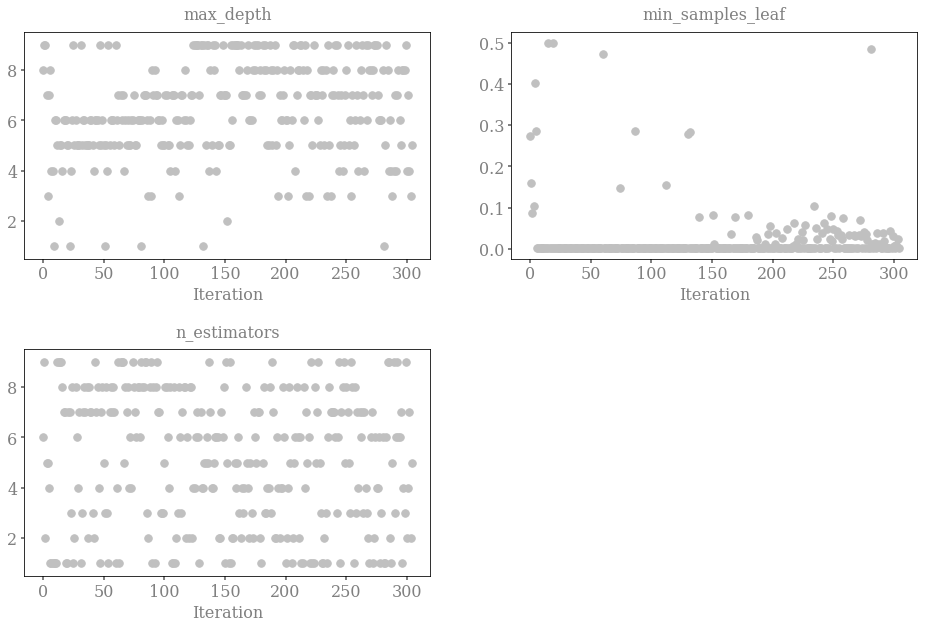

In [331]:
BOout.hyperparameter_convergence_plots()

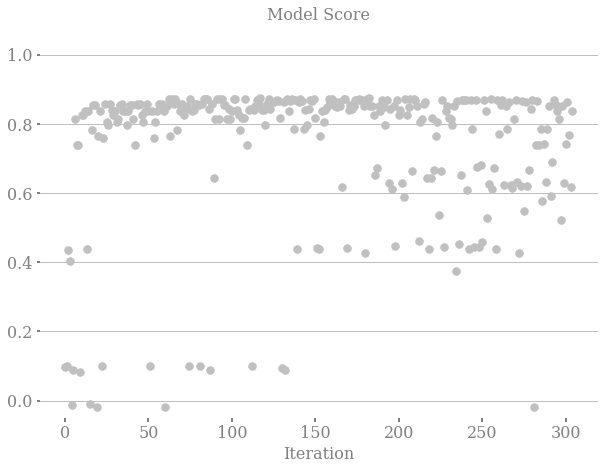

In [332]:
BOout.model_accuracy_convergence_plot()

In [333]:
BOout.best_params_vals

array([8.e+00, 1.e-03, 8.e+00])

# Ignore this for now...

In [165]:
# X = np.zeros((ndim, len(hps)))
# X[:, 0] = np.random.choice(hps[sorted(hps)[0]], size = ndim)#BOout.best_params_vals[0]
# X[:, 1] = np.linspace(0.1, 0.5, ndim)
# X[:, 2] = np.random.choice(hps[sorted(hps)[2]], size = ndim)#BOout.best_params_vals[2]

noise = 0.001
# x=np.linspace(0.1, 0.5).reshape(-1,1)
y, std = BOout.gpr.predict(X, return_std=True)
y1, std1 = GaussianProcessRegressor(kernel=RBF(), alpha=0.1).fit(BOout.Xt[:, 1].reshape(-1, 1), BOout.Yt).predict(X[:,1].reshape(-1, 1), return_std=True)
plt.plot(X[:,1], y)
# plt.plot(X[:,1], y - std, '--')
# plt.plot(X[:,1], y + std, '--')
plt.plot(BOout.Xt[:,1], BOout.Yt, '.')
plt.plot(X[:,1], y1, '.')

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

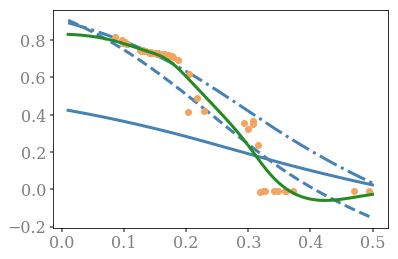

In [175]:
ndim = BOout.Xt.shape[0]

X = np.zeros((ndim, 4))
X[:, 0] = np.linspace(0.01, 0.5, ndim)
for i in range(1, 4):
    X[:, i] = i
    
plot_i = 1
y, std = BOout.gpr.predict(X[:, [0, plot_i]], return_std=True)
plot_i = 2
y_, std_ = BOout.gpr.predict(X[:, [0, plot_i]], return_std=True)
plot_i = 3
y__, std__ = BOout.gpr.predict(X[:, [0, plot_i]], return_std=True)

y1, std1 = GaussianProcessRegressor(kernel=Matern(), alpha=0.0125).fit(BOout.Xt[:, 0].reshape(-1, 1), BOout.Yt)\
    .predict(X[:,[0]], return_std=True)

plt.plot(X[:,0], y, color = 'steelblue', linewidth = 3)
plt.plot(X[:,0], y_, '--', color = 'steelblue', linewidth = 3)
plt.plot(X[:,0], y__, '-.', color = 'steelblue', linewidth = 3)
plt.plot(BOout.Xt[:,0], BOout.Yt, '.', color = 'sandybrown', markersize = 12)
plt.plot(X[:,0], y1, color = 'forestgreen', linewidth = 3)

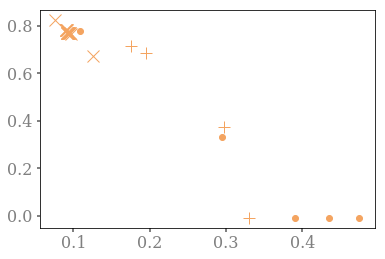

In [143]:
plt.plot(BOout.Xt[BOout.Xt[:, 1] == 1, 0], BOout.Yt[BOout.Xt[:, 1] == 1], 'x', color = 'sandybrown', markersize = 12)
plt.plot(BOout.Xt[BOout.Xt[:, 1] == 2, 0], BOout.Yt[BOout.Xt[:, 1] == 2], '.', color = 'sandybrown', markersize = 12)
plt.plot(BOout.Xt[BOout.Xt[:, 1] == 3, 0], BOout.Yt[BOout.Xt[:, 1] == 3], '+', color = 'sandybrown', markersize = 12)

In [26]:
noise = 0.001
# x=np.linspace(0.1, 0.5).reshape(-1,1)
y, std = BOout.gpr.predict(X, return_std=True)
y1, std1 = GaussianProcessRegressor(kernel=RBF(), alpha=0.1).fit(BOout.Xt[:, 1].reshape(-1, 1), BOout.Yt).predict(X[:,1].reshape(-1, 1), return_std=True)
plt.plot(X[:,1], y)
# plt.plot(X[:,1], y - std, '--')
# plt.plot(X[:,1], y + std, '--')
plt.plot(BOout.Xt[:,1], BOout.Yt, '.')
plt.plot(X[:,1], y1, '.')

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

In [146]:
y1


array([-1.83090872e-007,  9.33336254e-061,  3.23542516e-121,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        1.79261038e-119, -2.02127050e-301, -2.65832982e-301,
       -3.23918971e-242,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  4.76520317e-001,  0.00000000e+000,
        1.12019470e-295,  0.00000000e+000,  4.05230613e-060,
        6.15450612e-238,  0.00000000e+000, -2.00465774e-125,
        1.13053885e-059,  8.99325934e-120,  1.34607900e-059,
        0.00000000e+000, -1.08859087e-301,  6.85738453e-119,
        1.80735970e-237,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  6.00695818e-001,  0.00000000e+000,
        0.00000000e+000, -1.09054977e-298,  0.00000000e+000,
        0.00000000e+000,  1.08444270e-060,  1.98584291e-296,
       -4.03984531e-062,  0.00000000e+000,  0.00000000e+000,
       -9.88845497e-064,  0.00000000e+000, -2.94823117e-121,
        0.00000000e+000,